# The classifier of people with glasses 

The task is: implement a classifier for images with a human face, separating them into people with glasses and everyone else. It is assumed that the approach will be developed with an emphasis on its further use in a `mobile application in real-time`.

Limitations:
- common dependencies (opencv, dlib, numpy, scipy, tensorflow, ...) can be used, but they must be included in the installation instructions
- any pre-trained models or ready-made algorithms can be used
- any publicly available datasets for training and testing are allowed
- languages: C++, Python 

In [1]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, sys
os.chdir("..")
os.getcwd()

'E:\\sportstotal'

In [3]:
import os
import glob
import numpy as np
import cv2

# import matplotlib
# matplotlib.use('tkagg')
from matplotlib import pyplot as plt

In [ ]:
import torch

# Dataset

A sample set of 40 images has been provided by the team for testing (20 each for with/without glasses). In addition I have considered 3 more datasets for this project. Details of all datasets are mentioned below: 

1. Sample Test Set:
    - with_glasses = 20 jpeg images
    - without_glasses = 20 jpeg images

<br> 

2. SoF
    - Dataset page: https://sites.google.com/view/sof-dataset
    - Images download link: https://drive.google.com/file/d/1ufydwhMYtOhxgQuHs9SjERnkX0fXxorO/
    - Metadata download link: https://drive.google.com/file/d/0BwO0RMrZJCioaTVURnZoZG5jUVE/view?usp=sharing&resourcekey=0-F8-ejyF8NX4GC129ustqLg 

<br> 

3. Facial Landmark Detection by Deep Multi-task Learning:
    - Dataset Page: http://mmlab.ie.cuhk.edu.hk/projects/TCDCN.html
    - Images download link: http://mmlab.ie.cuhk.edu.hk/projects/TCDCN/data/MTFL.zip

<br> 

4. MeGlass:
    - Dataset Page: https://github.com/cleardusk/MeGlass/tree/master
    - Images download link: https://drive.google.com/file/d/1V0c8p6MOlSFY5R-Hu9LxYZYLXd8B8j9q/view?usp=sharing
    - Metadata download link: https://github.com/cleardusk/MeGlass/blob/master/meta.txt

## MTFL dataset

In [4]:
from pathlib import Path
import pandas as pd

In [5]:
mtfl_dataset = Path(".\data\MTFL")
mtfl_dataset

WindowsPath('data/MTFL')

In [83]:
train = pd.read_csv(mtfl_dataset.joinpath('training.txt'), 
                    sep=' ',
                    header=None,
                    skipinitialspace = True,
                    names=['Path']+['x1','x2','x3','x4','x5','y1','y2','y3','y4','y5']+['Gender','Smile','Glasses','Pose'])
train['Path'] = train['Path'].str.replace('\\','/')
print(train.shape)

(10001, 15)


In [84]:
'''
--x1...x5,y1...y5: the locations for left eye, right eye, nose, left mouth corner, right mouth corner.
--gender: 1 for male, 2 for female
--smile: 1 for smiling, 2 for not smiling
--glasses: 1 for wearing glasses, 2 for not wearing glasses.
--head pose: 1 for left profile, 2 for left, 3 for frontal, 4 for right, 5 for right profile
'''

train.head()

,Path,x1,x2,x3,x4,...,y5,Gender,Smile,Glasses,Pose
0,lfw_5590/Aaron_Eckhart_0001.jpg,107.25,147.75,126.25,106.25,...,162.75,1.0,2.0,2.0,3.0
1,lfw_5590/Aaron_Guiel_0001.jpg,101.25,146.75,125.25,93.75,...,164.75,1.0,1.0,2.0,3.0
2,lfw_5590/Aaron_Peirsol_0001.jpg,107.75,147.75,130.25,109.25,...,153.75,1.0,1.0,2.0,3.0
3,lfw_5590/Aaron_Pena_0001.jpg,102.75,146.25,126.25,120.75,...,156.75,1.0,2.0,2.0,3.0
4,lfw_5590/Aaron_Sorkin_0001.jpg,102.25,144.75,130.75,100.25,...,155.75,1.0,1.0,2.0,3.0


In [8]:
mtfl_glasses_map = {1:'With Glasses',2:'No Glasses'}
mtfl_pose_map = {1: '-60',2:'-30',3:'0',4:'+30',5:'+60'}

In [9]:
all_glass_images = train.loc[train['Glasses'] == 1]

(250, 250, 3)


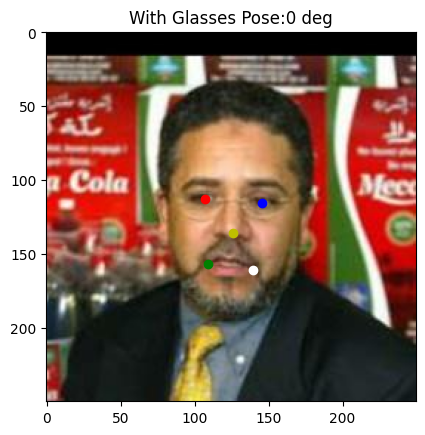

In [11]:
# visualizing a random image with keypoints
n = np.random.randint(low=2,high=1000)
row = all_glass_images.iloc[n]

img0 =  cv2.imread(str(mtfl_dataset.joinpath(row['Path'])))
img0 = cv2.cvtColor(img0,cv2.COLOR_BGR2RGB)
print(img0.shape)

plt.scatter(row['x1'],row['y1'],c='r')
plt.scatter(row['x2'],row['y2'],c='b')
plt.scatter(row['x3'],row['y3'],c='y')
plt.scatter(row['x4'],row['y4'],c='g')
plt.scatter(row['x5'],row['y5'],c='w')
plt.imshow(img0)
plt.title(f"{mtfl_glasses_map[int(row['Glasses'])]} Pose:{mtfl_pose_map[int(row['Pose'])]} deg")
plt.show()

## Approach-1: Train Yolov7 model to detect 5 landmark points and glasses. 



In [12]:
sys.path.append("yolov7-face")

In [37]:
from utils.plots import colors, plot_one_box
from utils.datasets import LoadStreams, LoadImages, letterbox
from utils.general import check_img_size, check_requirements, check_imshow, set_logging 
from utils.general import non_max_suppression, apply_classifier, scale_coords, xyxy2xywh 
from utils.general import strip_optimizer, increment_path, save_one_box

from utils.plots import colors, plot_one_box

In [14]:
weights = "./pretrained_models/yolov7-lite-s.pt"

In [15]:
model = attempt_load(weights, map_location='cpu')

C:\Users\Pradip.Gupta\.conda\envs\berlin\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [16]:
model

Model(
  (model): Sequential(
    (0): StemBlock(
      (stem_1): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (stem_2a): Conv(
        (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
      (stem_2b): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (stem_2p): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (stem_3): Conv(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
    )
    (1): Shuffle_Block(
      (branch1): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (2): Conv2d(32, 48, kernel_size=(1, 1), str

In [17]:
names = model.names
names

['face']

In [18]:
model.eval()

Model(
  (model): Sequential(
    (0): StemBlock(
      (stem_1): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (stem_2a): Conv(
        (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
      (stem_2b): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (stem_2p): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (stem_3): Conv(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
    )
    (1): Shuffle_Block(
      (branch1): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (2): Conv2d(32, 48, kernel_size=(1, 1), str

In [19]:
stride = int(model.stride.max())  # model stride
stride 

32

In [20]:
device = 'cpu'

In [21]:
imgsz = 640

In [24]:
img = letterbox(img0, imgsz)[0]
img = img.transpose(2, 0, 1)  # CHW
img = np.ascontiguousarray(img)
img = torch.from_numpy(img).to(device)
img = img.float()
img /= 255.0  # 0 - 255 to 0.0 - 1.0
if img.ndimension() == 3:
    img = img.unsqueeze(0)

In [25]:
img.shape, img.dtype

(torch.Size([1, 3, 640, 640]), torch.float32)

In [26]:
with torch.no_grad():
    result = model(img, augment=False)

In [27]:
len(result)

2

In [28]:
pred = non_max_suppression(result[0])

In [29]:
pred

[tensor([[217.41495, 165.95018, 434.95792, 479.33533,   0.80886,   0.00000, 278.27618, 284.89334,   0.99710, 373.90973, 291.82513,   0.99750, 321.52219, 347.94031,   0.99817, 281.80371, 402.36151,   0.99692, 353.43430, 408.16495,   0.99106]])]

In [30]:
for i, det in enumerate(pred):
    print(det)

tensor([[217.41495, 165.95018, 434.95792, 479.33533,   0.80886,   0.00000, 278.27618, 284.89334,   0.99710, 373.90973, 291.82513,   0.99750, 321.52219, 347.94031,   0.99817, 281.80371, 402.36151,   0.99692, 353.43430, 408.16495,   0.99106]])


In [31]:
for i, det in enumerate(pred):  # detections per image
    gn = torch.tensor(img0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
    if len(det):
        # Rescale boxes from img_size to im0 size
        scale_coords(img.shape[2:], det[:, :4], img0.shape, kpt_label=False)
        scale_coords(img.shape[2:], det[:, 6:], img0.shape, kpt_label=5, step=3)

        # Print results
        for c in det[:, 5].unique():
            n = (det[:, 5] == c).sum()  # detections per class

        # Write results
        for det_index, (*xyxy, conf, cls) in enumerate(det[:,:6]):
            c = int(cls)  # integer class
            label = f'{names[c]} {conf:.2f}'
            kpts = det[det_index, 6:]
            x1 = int(xyxy[0] + 0.5)
            y1 = int(xyxy[1] + 0.5)
            x2 = int(xyxy[2] + 0.5)
            y2 = int(xyxy[3] + 0.5)

In [36]:
len(kpts)

15

In [ ]:
xyxy

In [32]:
plot_one_box(xyxy, img0, label=label, color=colors(c, True), 
             kpt_label=5, kpts=kpts, steps=3, orig_shape=img0.shape[:2])

In [33]:
cv2.imwrite('result.jpg', img0)

True

# Covert MTFL dataset to yolo format

In [41]:
import os
import random
import cv2
import pandas as pd
import numpy as np
random_seed = 42
random.seed(random_seed)

In [103]:
# Set your paths and parameters
mtfl_path = r'E:\sportstotal\data\MTFL'
output_path = r'E:\sportstotal\data\yolo_MTFL'
train_ratio = 0.8


In [104]:
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [105]:
# Read the annotations file
annotations = pd.read_csv(os.path.join(mtfl_path, 'training.txt'), sep=' ', header=None, skipinitialspace=True)

In [106]:
# Split the dataset
train_data, val_data = np.split(annotations.sample(frac=1, random_state=random_seed), [int(train_ratio*len(annotations))])

In [107]:
# Save the train/val file list
train_data[0].to_csv(os.path.join(output_path, 'training.txt'), index=False, header=False)
val_data[0].to_csv(os.path.join(output_path, 'validation.txt'), index=False, header=False)

In [112]:
# Function to convert the annotations to YOLO format
def convert_to_yolo(annotations, output_path):
    for index, row in annotations.iterrows():
        img_path = os.path.join(mtfl_path, row[0])
#         print(img_path)
        img = cv2.imread(img_path)
        height, width, _ = img.shape
        yolo_annots = []

        # Keypoints
        for i in range(5):
            x, y = row[i+1], row[i+6]
#             print(f"keypoint: {x,y}")
            yolo_x, yolo_y = x / width, y / height
            yolo_annots.append(f"{i} {yolo_x} {yolo_y} 0.01 0.01")

        # Glasses detection
        glasses = int(row[13])
        if glasses == 1:
            x1, y1 = row[1], row[6]
            x2, y2 = row[2], row[7]
#             print(x1, y1, x2, y2)
            xmin = min(x1, x2)
            ymin = min(y1, y2)
            xmax = max(x1, x2)
            ymax = max(y1, y2)
            yolo_x = (xmin + xmax) / (2 * width)
            yolo_y = (ymin + ymax) / (2 * height)
            yolo_w = (xmax - xmin) / width
            yolo_h = (ymax - ymin) / height
            yolo_annots.append(f"5 {yolo_x} {yolo_y} {yolo_w} {yolo_h}")

        # Save the YOLO annotations
        yolo_annot_path = os.path.join(output_path, os.path.splitext(row[0])[0] + '.txt')
        with open(yolo_annot_path, 'w') as f:
            f.write('\n'.join(yolo_annots))

In [111]:
# Convert the annotations
convert_to_yolo(train_data, output_path)

E:\sportstotal\data\MTFL\net_7876\7183_0_0.jpg
keypoint: (140.0, 157.0)
keypoint: (226.0, 151.0)
keypoint: (183.0, 210.0)
keypoint: (153.0, 243.0)
keypoint: (241.0, 236.0)
140.0 157.0 226.0 151.0
E:\sportstotal\data\MTFL\net_7876\1872_0_0.jpg
keypoint: (167.0, 141.0)
keypoint: (256.0, 162.0)
keypoint: (213.0, 219.0)
keypoint: (152.0, 242.0)
keypoint: (224.0, 262.0)
E:\sportstotal\data\MTFL\lfw_5590\Jamir_Miller_0001.jpg
keypoint: (100.25, 112.25)
keypoint: (150.75, 113.75)
keypoint: (125.25, 137.75)
keypoint: (102.75, 158.75)
keypoint: (147.25, 157.75)
E:\sportstotal\data\MTFL\net_7876\224_0_0.jpg
keypoint: (158.0, 154.0)
keypoint: (236.0, 162.0)
keypoint: (168.0, 196.0)
keypoint: (151.0, 253.0)
keypoint: (198.0, 258.0)
E:\sportstotal\data\MTFL\net_7876\1608_0_0.jpg
keypoint: (155.0, 143.0)
keypoint: (252.0, 150.0)
keypoint: (200.0, 207.0)
keypoint: (159.0, 255.0)
keypoint: (229.0, 260.0)
E:\sportstotal\data\MTFL\net_7876\7337_0_0.jpg
keypoint: (165.0, 153.0)
keypoint: (262.0, 146.0)
k

E:\sportstotal\data\MTFL\lfw_5590\Thomas_Bjorn_0001.jpg
keypoint: (106.25, 111.25)
keypoint: (149.25, 113.25)
keypoint: (121.75, 138.25)
keypoint: (102.75, 153.75)
keypoint: (142.25, 156.25)
E:\sportstotal\data\MTFL\net_7876\6548_0_0.jpg
keypoint: (178.0, 150.0)
keypoint: (263.0, 161.0)
keypoint: (241.0, 209.0)
keypoint: (175.0, 247.0)
keypoint: (247.0, 260.0)
E:\sportstotal\data\MTFL\lfw_5590\Peter_Hillary_0001.jpg
keypoint: (107.75, 106.25)
keypoint: (152.75, 116.75)
keypoint: (127.75, 145.75)
keypoint: (96.75, 154.25)
keypoint: (144.75, 165.25)
E:\sportstotal\data\MTFL\lfw_5590\Rene_Portland_0001.jpg
keypoint: (107.25, 110.25)
keypoint: (150.25, 108.75)
keypoint: (125.75, 132.75)
keypoint: (112.75, 160.25)
keypoint: (145.75, 160.75)
E:\sportstotal\data\MTFL\lfw_5590\Orrin_Hatch_0001.jpg
keypoint: (100.25, 118.75)
keypoint: (144.75, 110.25)
keypoint: (118.75, 144.75)
keypoint: (122.25, 176.75)
keypoint: (153.75, 172.75)
E:\sportstotal\data\MTFL\net_7876\_0_1218_1.jpg
keypoint: (66.0,

keypoint: (62.0, 66.0)
keypoint: (94.0, 58.0)
keypoint: (81.0, 84.0)
keypoint: (76.0, 100.0)
keypoint: (100.0, 95.0)
E:\sportstotal\data\MTFL\lfw_5590\Ken_Macha_0001.jpg
keypoint: (101.75, 112.75)
keypoint: (152.25, 109.75)
keypoint: (124.75, 139.25)
keypoint: (108.75, 165.75)
keypoint: (150.25, 163.75)
E:\sportstotal\data\MTFL\lfw_5590\Din_Samsudin_0001.jpg
keypoint: (101.75, 117.75)
keypoint: (138.75, 110.25)
keypoint: (113.25, 139.75)
keypoint: (112.75, 160.75)
keypoint: (140.75, 156.75)
E:\sportstotal\data\MTFL\net_7876\_40_1764_0.jpg
keypoint: (63.0, 64.0)
keypoint: (98.0, 60.0)
keypoint: (90.0, 81.0)
keypoint: (66.0, 95.0)
keypoint: (99.0, 92.0)
E:\sportstotal\data\MTFL\net_7876\853_0_0.jpg
keypoint: (155.0, 140.0)
keypoint: (250.0, 143.0)
keypoint: (193.0, 207.0)
keypoint: (163.0, 247.0)
keypoint: (243.0, 248.0)
E:\sportstotal\data\MTFL\net_7876\8090_0_0.jpg
keypoint: (128.0, 168.0)
keypoint: (211.0, 148.0)
keypoint: (142.0, 212.0)
keypoint: (153.0, 268.0)
keypoint: (215.0, 250.

keypoint: (161.0, 146.0)
keypoint: (255.0, 156.0)
keypoint: (228.0, 218.0)
keypoint: (150.0, 250.0)
keypoint: (234.0, 256.0)
E:\sportstotal\data\MTFL\lfw_5590\Teresa_Williams_0001.jpg
keypoint: (105.75, 109.75)
keypoint: (150.75, 116.25)
keypoint: (128.25, 134.75)
keypoint: (104.25, 152.75)
keypoint: (144.25, 160.25)
E:\sportstotal\data\MTFL\net_7876\_-60_9279_0.jpg
keypoint: (69.0, 59.0)
keypoint: (93.0, 62.0)
keypoint: (67.0, 77.0)
keypoint: (70.0, 96.0)
keypoint: (90.0, 100.0)
E:\sportstotal\data\MTFL\net_7876\1255_0_0.jpg
keypoint: (160.0, 152.0)
keypoint: (239.0, 153.0)
keypoint: (202.0, 206.0)
keypoint: (171.0, 254.0)
keypoint: (238.0, 253.0)
E:\sportstotal\data\MTFL\lfw_5590\Robert_Gallo_0001.jpg
keypoint: (107.75, 115.25)
keypoint: (147.75, 112.25)
keypoint: (132.75, 137.25)
keypoint: (112.75, 160.25)
keypoint: (145.25, 159.25)
E:\sportstotal\data\MTFL\net_7876\242_0_0.jpg
keypoint: (132.0, 128.0)
keypoint: (248.0, 130.0)
keypoint: (191.0, 210.0)
keypoint: (144.0, 250.0)
keypoi

keypoint: (148.0, 167.0)
keypoint: (231.0, 154.0)
keypoint: (175.0, 212.0)
keypoint: (164.0, 240.0)
keypoint: (250.0, 229.0)
E:\sportstotal\data\MTFL\net_7876\7029_0_0.jpg
keypoint: (162.0, 150.0)
keypoint: (246.0, 160.0)
keypoint: (204.0, 178.0)
keypoint: (147.0, 225.0)
keypoint: (245.0, 237.0)
E:\sportstotal\data\MTFL\net_7876\472_0_0.jpg
keypoint: (127.0, 169.0)
keypoint: (266.0, 155.0)
keypoint: (194.0, 187.0)
keypoint: (146.0, 249.0)
keypoint: (257.0, 243.0)
E:\sportstotal\data\MTFL\net_7876\5186_0_0.jpg
keypoint: (151.0, 152.0)
keypoint: (245.0, 144.0)
keypoint: (211.0, 204.0)
keypoint: (157.0, 254.0)
keypoint: (257.0, 243.0)
E:\sportstotal\data\MTFL\net_7876\_-40_2273_0.jpg
keypoint: (65.0, 62.0)
keypoint: (98.0, 61.0)
keypoint: (74.0, 84.0)
keypoint: (71.0, 102.0)
keypoint: (94.0, 102.0)
65.0 62.0 98.0 61.0
E:\sportstotal\data\MTFL\net_7876\204_0_0.jpg
keypoint: (165.0, 170.0)
keypoint: (254.0, 168.0)
keypoint: (207.0, 219.0)
keypoint: (173.0, 265.0)
keypoint: (249.0, 262.0)
16

keypoint: (71.0, 70.0)
keypoint: (97.0, 69.0)
keypoint: (82.0, 88.0)
keypoint: (73.0, 96.0)
keypoint: (96.0, 95.0)
E:\sportstotal\data\MTFL\net_7876\6625_0_0.jpg
keypoint: (158.0, 134.0)
keypoint: (266.0, 160.0)
keypoint: (193.0, 217.0)
keypoint: (144.0, 233.0)
keypoint: (235.0, 255.0)
158.0 134.0 266.0 160.0
E:\sportstotal\data\MTFL\lfw_5590\Hasan_Wirayuda_0001.jpg
keypoint: (109.75, 109.75)
keypoint: (152.75, 109.75)
keypoint: (138.75, 137.75)
keypoint: (110.75, 162.25)
keypoint: (148.25, 163.75)
109.75 109.75 152.75 109.75
E:\sportstotal\data\MTFL\net_7876\1062_1_0.jpg
keypoint: (153.0, 137.0)
keypoint: (263.0, 140.0)
keypoint: (215.0, 198.0)
keypoint: (163.0, 258.0)
keypoint: (249.0, 263.0)
153.0 137.0 263.0 140.0
E:\sportstotal\data\MTFL\net_7876\9303_0_0.jpg
keypoint: (159.0, 145.0)
keypoint: (240.0, 144.0)
keypoint: (182.0, 187.0)
keypoint: (170.0, 246.0)
keypoint: (229.0, 245.0)
E:\sportstotal\data\MTFL\net_7876\_-60_6446_2.jpg
keypoint: (72.0, 69.0)
keypoint: (97.0, 63.0)
keyp

keypoint: (144.0, 144.0)
keypoint: (226.0, 153.0)
keypoint: (151.0, 202.0)
keypoint: (142.0, 231.0)
keypoint: (206.0, 246.0)
E:\sportstotal\data\MTFL\net_7876\8497_0_0.jpg
keypoint: (128.0, 164.0)
keypoint: (209.0, 157.0)
keypoint: (196.0, 218.0)
keypoint: (139.0, 261.0)
keypoint: (222.0, 249.0)
E:\sportstotal\data\MTFL\net_7876\918_0_0.jpg
keypoint: (154.0, 156.0)
keypoint: (248.0, 150.0)
keypoint: (199.0, 204.0)
keypoint: (165.0, 261.0)
keypoint: (243.0, 258.0)
154.0 156.0 248.0 150.0
E:\sportstotal\data\MTFL\lfw_5590\Eladio_Larez_0001.jpg
keypoint: (102.75, 109.75)
keypoint: (148.25, 106.25)
keypoint: (123.25, 138.25)
keypoint: (108.25, 158.25)
keypoint: (144.25, 157.75)
E:\sportstotal\data\MTFL\lfw_5590\Bob_Stoops_0001.jpg
keypoint: (102.75, 116.25)
keypoint: (141.25, 111.75)
keypoint: (112.25, 133.75)
keypoint: (112.75, 160.25)
keypoint: (140.75, 157.75)
E:\sportstotal\data\MTFL\net_7876\7246_0_0.jpg
keypoint: (158.0, 149.0)
keypoint: (247.0, 153.0)
keypoint: (196.0, 208.0)
keypoi

keypoint: (152.0, 150.0)
keypoint: (249.0, 151.0)
keypoint: (214.0, 215.0)
keypoint: (154.0, 250.0)
keypoint: (252.0, 245.0)
E:\sportstotal\data\MTFL\lfw_5590\Patty_Duke_0001.jpg
keypoint: (104.75, 113.75)
keypoint: (148.25, 113.75)
keypoint: (128.75, 139.25)
keypoint: (105.75, 156.75)
keypoint: (147.25, 155.75)
E:\sportstotal\data\MTFL\lfw_5590\George_Maxwell_Richards_0001.jpg
keypoint: (103.75, 112.75)
keypoint: (146.25, 115.25)
keypoint: (132.25, 140.75)
keypoint: (103.75, 165.75)
keypoint: (139.75, 168.75)
103.75 112.75 146.25 115.25
E:\sportstotal\data\MTFL\net_7876\1595_0_0.jpg
keypoint: (159.0, 150.0)
keypoint: (223.0, 163.0)
keypoint: (159.0, 206.0)
keypoint: (153.0, 235.0)
keypoint: (217.0, 249.0)
E:\sportstotal\data\MTFL\net_7876\5974_0_0.jpg
keypoint: (160.0, 144.0)
keypoint: (248.0, 146.0)
keypoint: (221.0, 199.0)
keypoint: (171.0, 239.0)
keypoint: (248.0, 240.0)
E:\sportstotal\data\MTFL\net_7876\5538_0_0.jpg
keypoint: (141.0, 134.0)
keypoint: (254.0, 151.0)
keypoint: (188.

keypoint: (152.0, 137.0)
keypoint: (257.0, 143.0)
keypoint: (205.0, 218.0)
keypoint: (151.0, 253.0)
keypoint: (243.0, 262.0)
E:\sportstotal\data\MTFL\lfw_5590\Emile_Lahoud_0001.jpg
keypoint: (130.75, 127.75)
keypoint: (168.75, 126.25)
keypoint: (163.25, 161.25)
keypoint: (123.25, 182.25)
keypoint: (157.75, 181.25)
E:\sportstotal\data\MTFL\net_7876\8712_0_0.jpg
keypoint: (168.0, 134.0)
keypoint: (262.0, 153.0)
keypoint: (227.0, 212.0)
keypoint: (144.0, 234.0)
keypoint: (239.0, 250.0)
E:\sportstotal\data\MTFL\lfw_5590\Horst_Koehler_0001.jpg
keypoint: (105.25, 119.25)
keypoint: (142.25, 107.75)
keypoint: (126.75, 137.25)
keypoint: (118.75, 158.25)
keypoint: (149.25, 151.75)
E:\sportstotal\data\MTFL\lfw_5590\Edward_Johnson_0001.jpg
keypoint: (109.75, 107.25)
keypoint: (147.25, 112.75)
keypoint: (130.25, 134.75)
keypoint: (104.25, 154.75)
keypoint: (136.75, 162.25)
109.75 107.25 147.25 112.75
E:\sportstotal\data\MTFL\net_7876\6931_0_0.jpg
keypoint: (165.0, 148.0)
keypoint: (250.0, 148.0)
ke

keypoint: (198.0, 158.0)
keypoint: (262.0, 163.0)
keypoint: (248.0, 207.0)
keypoint: (174.0, 248.0)
keypoint: (235.0, 255.0)
E:\sportstotal\data\MTFL\lfw_5590\Richard_Naughton_0001.jpg
keypoint: (104.75, 114.25)
keypoint: (150.25, 112.25)
keypoint: (126.75, 136.75)
keypoint: (109.75, 159.75)
keypoint: (146.75, 159.25)
E:\sportstotal\data\MTFL\lfw_5590\Ozzy_Osbourne_0001.jpg
keypoint: (102.75, 114.75)
keypoint: (149.75, 111.75)
keypoint: (127.25, 140.75)
keypoint: (105.25, 172.75)
keypoint: (149.25, 170.25)
E:\sportstotal\data\MTFL\net_7876\_20_100_0.jpg
keypoint: (63.0, 67.0)
keypoint: (97.0, 57.0)
keypoint: (83.0, 76.0)
keypoint: (77.0, 96.0)
keypoint: (98.0, 91.0)
E:\sportstotal\data\MTFL\net_7876\_40_1127_0.jpg
keypoint: (66.0, 59.0)
keypoint: (96.0, 67.0)
keypoint: (88.0, 81.0)
keypoint: (63.0, 98.0)
keypoint: (90.0, 107.0)
E:\sportstotal\data\MTFL\lfw_5590\George_Tenet_0001.jpg
keypoint: (108.25, 113.75)
keypoint: (145.25, 113.25)
keypoint: (126.75, 131.75)
keypoint: (114.75, 153.

keypoint: (145.0, 158.0)
keypoint: (231.0, 143.0)
keypoint: (187.0, 216.0)
keypoint: (162.0, 240.0)
keypoint: (256.0, 223.0)
E:\sportstotal\data\MTFL\net_7876\7127_0_0.jpg
keypoint: (165.0, 146.0)
keypoint: (250.0, 144.0)
keypoint: (214.0, 187.0)
keypoint: (174.0, 226.0)
keypoint: (245.0, 225.0)
E:\sportstotal\data\MTFL\lfw_5590\Kristin_Davis_0001.jpg
keypoint: (110.25, 112.75)
keypoint: (154.75, 110.25)
keypoint: (136.75, 139.75)
keypoint: (112.75, 153.75)
keypoint: (149.75, 151.75)
E:\sportstotal\data\MTFL\net_7876\_60_924_0.jpg
keypoint: (73.0, 65.0)
keypoint: (105.0, 62.0)
keypoint: (98.0, 89.0)
keypoint: (72.0, 105.0)
keypoint: (96.0, 104.0)
73.0 65.0 105.0 62.0
E:\sportstotal\data\MTFL\net_7876\9487_0_0.jpg
keypoint: (156.0, 167.0)
keypoint: (239.0, 156.0)
keypoint: (198.0, 210.0)
keypoint: (174.0, 274.0)
keypoint: (243.0, 266.0)
E:\sportstotal\data\MTFL\lfw_5590\Eric_Staal_0001.jpg
keypoint: (104.75, 111.75)
keypoint: (148.25, 115.25)
keypoint: (126.75, 134.25)
keypoint: (108.25

keypoint: (157.0, 155.0)
keypoint: (221.0, 162.0)
keypoint: (156.0, 204.0)
keypoint: (156.0, 257.0)
keypoint: (216.0, 261.0)
E:\sportstotal\data\MTFL\lfw_5590\Dave_Odom_0001.jpg
keypoint: (108.25, 117.75)
keypoint: (148.75, 113.25)
keypoint: (121.75, 135.25)
keypoint: (114.25, 168.25)
keypoint: (145.75, 164.75)
108.25 117.75 148.75 113.25
E:\sportstotal\data\MTFL\lfw_5590\Floyd_Mayweather_0001.jpg
keypoint: (108.25, 119.25)
keypoint: (144.75, 111.75)
keypoint: (122.75, 139.25)
keypoint: (113.25, 156.75)
keypoint: (154.75, 148.25)
E:\sportstotal\data\MTFL\net_7876\_20_1201_0.jpg
keypoint: (65.0, 64.0)
keypoint: (95.0, 63.0)
keypoint: (83.0, 82.0)
keypoint: (67.0, 97.0)
keypoint: (94.0, 96.0)
E:\sportstotal\data\MTFL\net_7876\6536_0_0.jpg
keypoint: (159.0, 153.0)
keypoint: (248.0, 153.0)
keypoint: (212.0, 215.0)
keypoint: (164.0, 250.0)
keypoint: (242.0, 253.0)
E:\sportstotal\data\MTFL\net_7876\6299_1_0.jpg
keypoint: (145.0, 152.0)
keypoint: (248.0, 134.0)
keypoint: (205.0, 212.0)
keypoi

keypoint: (74.0, 66.0)
keypoint: (95.0, 65.0)
keypoint: (97.0, 84.0)
keypoint: (72.0, 95.0)
keypoint: (95.0, 93.0)
E:\sportstotal\data\MTFL\net_7876\_60_4805_0.jpg
keypoint: (70.0, 60.0)
keypoint: (99.0, 66.0)
keypoint: (100.0, 87.0)
keypoint: (65.0, 101.0)
keypoint: (93.0, 105.0)
E:\sportstotal\data\MTFL\net_7876\8_0_0.jpg
keypoint: (157.0, 148.0)
keypoint: (264.0, 131.0)
keypoint: (239.0, 205.0)
keypoint: (165.0, 245.0)
keypoint: (276.0, 224.0)
E:\sportstotal\data\MTFL\lfw_5590\Gideon_Yago_0001.jpg
keypoint: (106.25, 113.75)
keypoint: (149.75, 109.75)
keypoint: (134.75, 137.75)
keypoint: (113.75, 159.25)
keypoint: (158.75, 152.25)
106.25 113.75 149.75 109.75
E:\sportstotal\data\MTFL\lfw_5590\Paul_ONeill_0001.jpg
keypoint: (102.25, 112.25)
keypoint: (149.25, 113.25)
keypoint: (131.75, 138.25)
keypoint: (105.25, 159.75)
keypoint: (140.25, 161.25)
102.25 112.25 149.25 113.25
E:\sportstotal\data\MTFL\lfw_5590\Tom_Brady_0001.jpg
keypoint: (108.75, 115.25)
keypoint: (149.25, 111.75)
keypoi

keypoint: (150.0, 130.0)
keypoint: (256.0, 132.0)
keypoint: (208.0, 225.0)
keypoint: (151.0, 243.0)
keypoint: (236.0, 240.0)
E:\sportstotal\data\MTFL\lfw_5590\Wycliffe_Grousbeck_0001.jpg
keypoint: (110.25, 109.25)
keypoint: (144.75, 121.25)
keypoint: (134.75, 138.75)
keypoint: (100.75, 150.75)
keypoint: (130.75, 162.25)
E:\sportstotal\data\MTFL\net_7876\7002_0_0.jpg
keypoint: (156.0, 147.0)
keypoint: (253.0, 150.0)
keypoint: (192.0, 191.0)
keypoint: (156.0, 258.0)
keypoint: (229.0, 262.0)
E:\sportstotal\data\MTFL\lfw_5590\Abdullah_0001.jpg
keypoint: (107.25, 113.75)
keypoint: (149.25, 114.25)
keypoint: (127.75, 133.25)
keypoint: (111.25, 156.25)
keypoint: (138.75, 156.75)
E:\sportstotal\data\MTFL\lfw_5590\Suzanne_Torrance_0001.jpg
keypoint: (102.75, 111.75)
keypoint: (147.25, 108.25)
keypoint: (126.25, 131.75)
keypoint: (105.75, 152.25)
keypoint: (148.25, 149.75)
102.75 111.75 147.25 108.25
E:\sportstotal\data\MTFL\net_7876\_20_1389_0.jpg
keypoint: (67.0, 66.0)
keypoint: (98.0, 71.0)
k

keypoint: (64.0, 65.0)
keypoint: (96.0, 66.0)
keypoint: (77.0, 83.0)
keypoint: (68.0, 99.0)
keypoint: (97.0, 99.0)
E:\sportstotal\data\MTFL\net_7876\6746_0_0.jpg
keypoint: (171.0, 142.0)
keypoint: (262.0, 149.0)
keypoint: (220.0, 213.0)
keypoint: (143.0, 247.0)
keypoint: (245.0, 253.0)
E:\sportstotal\data\MTFL\lfw_5590\Wendy_Kennedy_0001.jpg
keypoint: (104.25, 115.75)
keypoint: (142.75, 112.75)
keypoint: (128.75, 133.75)
keypoint: (111.75, 156.25)
keypoint: (142.75, 153.25)
E:\sportstotal\data\MTFL\net_7876\458_0_0.jpg
keypoint: (150.0, 155.0)
keypoint: (240.0, 148.0)
keypoint: (198.0, 201.0)
keypoint: (163.0, 251.0)
keypoint: (237.0, 246.0)
150.0 155.0 240.0 148.0
E:\sportstotal\data\MTFL\lfw_5590\Garry_Kasparov_0001.jpg
keypoint: (108.75, 113.25)
keypoint: (147.75, 117.25)
keypoint: (117.75, 138.25)
keypoint: (107.75, 159.75)
keypoint: (136.75, 161.75)
E:\sportstotal\data\MTFL\net_7876\_60_1789_0.jpg
keypoint: (64.0, 63.0)
keypoint: (95.0, 61.0)
keypoint: (84.0, 76.0)
keypoint: (74.0

keypoint: (65.0, 62.0)
keypoint: (96.0, 63.0)
keypoint: (91.0, 83.0)
keypoint: (63.0, 95.0)
keypoint: (92.0, 94.0)
E:\sportstotal\data\MTFL\net_7876\_20_1420_0.jpg
keypoint: (64.0, 55.0)
keypoint: (96.0, 63.0)
keypoint: (79.0, 83.0)
keypoint: (51.0, 85.0)
keypoint: (84.0, 94.0)
E:\sportstotal\data\MTFL\lfw_5590\Clara_Harris_0001.jpg
keypoint: (106.75, 112.75)
keypoint: (139.75, 116.75)
keypoint: (109.75, 134.25)
keypoint: (103.25, 154.75)
keypoint: (129.75, 158.75)
E:\sportstotal\data\MTFL\lfw_5590\Angie_Martinez_0001.jpg
keypoint: (110.25, 109.75)
keypoint: (147.25, 110.75)
keypoint: (114.75, 129.75)
keypoint: (111.25, 151.25)
keypoint: (144.25, 152.75)
110.25 109.75 147.25 110.75
E:\sportstotal\data\MTFL\lfw_5590\Peter_Mackay_0001.jpg
keypoint: (106.25, 115.75)
keypoint: (147.25, 112.25)
keypoint: (133.25, 156.25)
keypoint: (110.25, 171.25)
keypoint: (138.25, 169.75)
106.25 115.75 147.25 112.25
E:\sportstotal\data\MTFL\lfw_5590\Chang_Tso_0001.jpg
keypoint: (106.75, 115.25)
keypoint: 

keypoint: (66.0, 67.0)
keypoint: (98.0, 69.0)
keypoint: (82.0, 84.0)
keypoint: (63.0, 94.0)
keypoint: (95.0, 98.0)
E:\sportstotal\data\MTFL\net_7876\9464_0_0.jpg
keypoint: (134.0, 166.0)
keypoint: (215.0, 140.0)
keypoint: (189.0, 211.0)
keypoint: (174.0, 272.0)
keypoint: (247.0, 243.0)
E:\sportstotal\data\MTFL\net_7876\6008_0_0.jpg
keypoint: (193.0, 166.0)
keypoint: (286.0, 188.0)
keypoint: (261.0, 188.0)
keypoint: (202.0, 256.0)
keypoint: (271.0, 265.0)
E:\sportstotal\data\MTFL\net_7876\_-20_1407_0.jpg
keypoint: (64.0, 70.0)
keypoint: (93.0, 66.0)
keypoint: (79.0, 84.0)
keypoint: (69.0, 106.0)
keypoint: (99.0, 101.0)
E:\sportstotal\data\MTFL\net_7876\5016_0_0.jpg
keypoint: (150.0, 148.0)
keypoint: (246.0, 146.0)
keypoint: (196.0, 229.0)
keypoint: (148.0, 256.0)
keypoint: (246.0, 256.0)
E:\sportstotal\data\MTFL\net_7876\5390_0_0.jpg
keypoint: (162.0, 142.0)
keypoint: (253.0, 145.0)
keypoint: (208.0, 215.0)
keypoint: (159.0, 244.0)
keypoint: (247.0, 245.0)
E:\sportstotal\data\MTFL\net_7

keypoint: (97.75, 107.25)
keypoint: (142.25, 106.75)
keypoint: (116.75, 132.75)
keypoint: (98.75, 156.25)
keypoint: (147.25, 157.75)
E:\sportstotal\data\MTFL\net_7876\1166_0_0.jpg
keypoint: (137.0, 166.0)
keypoint: (236.0, 139.0)
keypoint: (213.0, 209.0)
keypoint: (176.0, 268.0)
keypoint: (258.0, 247.0)
E:\sportstotal\data\MTFL\net_7876\8008_0_0.jpg
keypoint: (165.0, 149.0)
keypoint: (261.0, 145.0)
keypoint: (230.0, 210.0)
keypoint: (179.0, 252.0)
keypoint: (260.0, 248.0)
E:\sportstotal\data\MTFL\lfw_5590\Anne_Donovan_0001.jpg
keypoint: (103.75, 109.25)
keypoint: (146.25, 112.75)
keypoint: (131.25, 135.75)
keypoint: (104.25, 160.75)
keypoint: (138.25, 161.25)
E:\sportstotal\data\MTFL\net_7876\6699_0_0.jpg
keypoint: (149.0, 148.0)
keypoint: (250.0, 149.0)
keypoint: (198.0, 210.0)
keypoint: (162.0, 260.0)
keypoint: (238.0, 259.0)
E:\sportstotal\data\MTFL\net_7876\6351_0_0.jpg
keypoint: (158.0, 149.0)
keypoint: (248.0, 145.0)
keypoint: (207.0, 218.0)
keypoint: (165.0, 242.0)
keypoint: (24

keypoint: (108.25, 116.75)
keypoint: (144.25, 115.25)
keypoint: (117.75, 135.75)
keypoint: (112.25, 163.75)
keypoint: (137.75, 162.75)
E:\sportstotal\data\MTFL\net_7876\1548_0_0.jpg
keypoint: (161.0, 157.0)
keypoint: (247.0, 152.0)
keypoint: (207.0, 221.0)
keypoint: (155.0, 241.0)
keypoint: (263.0, 237.0)
161.0 157.0 247.0 152.0
E:\sportstotal\data\MTFL\lfw_5590\Viktor_Yushchenko_0001.jpg
keypoint: (103.75, 115.75)
keypoint: (147.75, 108.75)
keypoint: (123.75, 141.75)
keypoint: (115.25, 166.75)
keypoint: (146.75, 161.75)
E:\sportstotal\data\MTFL\lfw_5590\Martin_Kristof_0001.jpg
keypoint: (110.25, 109.25)
keypoint: (148.75, 115.25)
keypoint: (129.25, 137.25)
keypoint: (99.25, 145.25)
keypoint: (142.75, 153.25)
E:\sportstotal\data\MTFL\net_7876\788_0_0.jpg
keypoint: (164.0, 146.0)
keypoint: (253.0, 155.0)
keypoint: (206.0, 210.0)
keypoint: (156.0, 229.0)
keypoint: (235.0, 243.0)
E:\sportstotal\data\MTFL\net_7876\7623_0_0.jpg
keypoint: (164.0, 137.0)
keypoint: (272.0, 164.0)
keypoint: (19

keypoint: (151.0, 147.0)
keypoint: (237.0, 155.0)
keypoint: (173.0, 188.0)
keypoint: (138.0, 241.0)
keypoint: (228.0, 255.0)
E:\sportstotal\data\MTFL\net_7876\_20_1026_0.jpg
keypoint: (58.0, 63.0)
keypoint: (97.0, 60.0)
keypoint: (88.0, 88.0)
keypoint: (65.0, 106.0)
keypoint: (93.0, 104.0)
E:\sportstotal\data\MTFL\net_7876\_40_1088_0.jpg
keypoint: (70.0, 63.0)
keypoint: (101.0, 72.0)
keypoint: (90.0, 93.0)
keypoint: (60.0, 107.0)
keypoint: (86.0, 112.0)
E:\sportstotal\data\MTFL\net_7876\6747_0_0.jpg
keypoint: (166.0, 151.0)
keypoint: (254.0, 148.0)
keypoint: (206.0, 207.0)
keypoint: (165.0, 249.0)
keypoint: (262.0, 249.0)
E:\sportstotal\data\MTFL\net_7876\_60_4571_0.jpg
keypoint: (69.0, 62.0)
keypoint: (96.0, 68.0)
keypoint: (88.0, 80.0)
keypoint: (68.0, 93.0)
keypoint: (94.0, 97.0)
E:\sportstotal\data\MTFL\lfw_5590\Katie_Smith_0001.jpg
keypoint: (106.25, 117.75)
keypoint: (147.25, 117.25)
keypoint: (130.75, 119.75)
keypoint: (115.75, 156.25)
keypoint: (150.75, 155.25)
E:\sportstotal\d

keypoint: (106.75, 107.25)
keypoint: (159.75, 114.75)
keypoint: (139.75, 128.75)
keypoint: (117.75, 159.25)
keypoint: (152.75, 163.75)
E:\sportstotal\data\MTFL\lfw_5590\Elvis_Costello_0001.jpg
keypoint: (109.75, 106.25)
keypoint: (152.25, 108.75)
keypoint: (129.25, 135.75)
keypoint: (109.25, 148.25)
keypoint: (142.75, 153.25)
109.75 106.25 152.25 108.75
E:\sportstotal\data\MTFL\net_7876\1132_0_0.jpg
keypoint: (163.0, 147.0)
keypoint: (255.0, 154.0)
keypoint: (232.0, 202.0)
keypoint: (171.0, 265.0)
keypoint: (235.0, 273.0)
E:\sportstotal\data\MTFL\lfw_5590\Yogi_Berra_0001.jpg
keypoint: (107.25, 117.75)
keypoint: (142.25, 111.25)
keypoint: (119.25, 138.25)
keypoint: (115.25, 153.25)
keypoint: (154.75, 150.25)
107.25 117.75 142.25 111.25
E:\sportstotal\data\MTFL\lfw_5590\Brad_Alexander_Smith_0001.jpg
keypoint: (107.75, 113.25)
keypoint: (148.75, 116.25)
keypoint: (130.25, 136.25)
keypoint: (101.75, 151.75)
keypoint: (141.25, 153.25)
E:\sportstotal\data\MTFL\lfw_5590\Nelson_Acosta_0001.jpg

keypoint: (66.0, 56.0)
keypoint: (99.0, 59.0)
keypoint: (84.0, 81.0)
keypoint: (69.0, 94.0)
keypoint: (90.0, 96.0)
66.0 56.0 99.0 59.0
E:\sportstotal\data\MTFL\net_7876\903_0_0.jpg
keypoint: (156.0, 158.0)
keypoint: (243.0, 138.0)
keypoint: (201.0, 210.0)
keypoint: (179.0, 260.0)
keypoint: (252.0, 244.0)
E:\sportstotal\data\MTFL\net_7876\_60_287_0.jpg
keypoint: (72.0, 63.0)
keypoint: (95.0, 61.0)
keypoint: (93.0, 82.0)
keypoint: (74.0, 100.0)
keypoint: (88.0, 99.0)
E:\sportstotal\data\MTFL\net_7876\_0_1076_0.jpg
keypoint: (63.0, 66.0)
keypoint: (92.0, 65.0)
keypoint: (77.0, 80.0)
keypoint: (64.0, 97.0)
keypoint: (92.0, 95.0)
E:\sportstotal\data\MTFL\net_7876\_0_134_0.jpg
keypoint: (64.0, 60.0)
keypoint: (93.0, 59.0)
keypoint: (79.0, 80.0)
keypoint: (64.0, 92.0)
keypoint: (91.0, 93.0)
64.0 60.0 93.0 59.0
E:\sportstotal\data\MTFL\net_7876\_-20_159_0.jpg
keypoint: (61.0, 60.0)
keypoint: (98.0, 60.0)
keypoint: (76.0, 83.0)
keypoint: (61.0, 93.0)
keypoint: (102.0, 94.0)
E:\sportstotal\data\

E:\sportstotal\data\MTFL\net_7876\7485_0_0.jpg
keypoint: (161.0, 146.0)
keypoint: (255.0, 160.0)
keypoint: (216.0, 221.0)
keypoint: (163.0, 253.0)
keypoint: (234.0, 259.0)
E:\sportstotal\data\MTFL\lfw_5590\Herb_Sendek_0001.jpg
keypoint: (107.25, 116.25)
keypoint: (135.75, 112.75)
keypoint: (113.75, 134.25)
keypoint: (111.25, 160.25)
keypoint: (143.25, 156.25)
E:\sportstotal\data\MTFL\lfw_5590\Cindy_Klassen_0001.jpg
keypoint: (106.75, 111.25)
keypoint: (147.75, 112.75)
keypoint: (124.75, 141.25)
keypoint: (104.75, 148.75)
keypoint: (147.75, 150.25)
E:\sportstotal\data\MTFL\net_7876\_-40_1960_0.jpg
keypoint: (62.0, 63.0)
keypoint: (89.0, 62.0)
keypoint: (70.0, 83.0)
keypoint: (71.0, 91.0)
keypoint: (97.0, 89.0)
E:\sportstotal\data\MTFL\net_7876\_0_1259_1.jpg
keypoint: (66.0, 62.0)
keypoint: (97.0, 66.0)
keypoint: (79.0, 82.0)
keypoint: (61.0, 89.0)
keypoint: (93.0, 93.0)
E:\sportstotal\data\MTFL\lfw_5590\Bode_Miller_0001.jpg
keypoint: (98.25, 108.75)
keypoint: (139.75, 101.75)
keypoint: 

keypoint: (67.0, 61.0)
keypoint: (99.0, 63.0)
keypoint: (73.0, 83.0)
keypoint: (68.0, 100.0)
keypoint: (90.0, 103.0)
E:\sportstotal\data\MTFL\net_7876\_-20_1201_1.jpg
keypoint: (63.0, 65.0)
keypoint: (98.0, 58.0)
keypoint: (75.0, 83.0)
keypoint: (70.0, 104.0)
keypoint: (101.0, 99.0)
E:\sportstotal\data\MTFL\lfw_5590\Osrat_Iosef_0001.jpg
keypoint: (112.25, 112.25)
keypoint: (146.75, 111.75)
keypoint: (142.75, 137.75)
keypoint: (111.75, 154.75)
keypoint: (142.75, 153.75)
E:\sportstotal\data\MTFL\net_7876\_-20_1045_3.jpg
keypoint: (66.0, 62.0)
keypoint: (95.0, 64.0)
keypoint: (76.0, 86.0)
keypoint: (70.0, 97.0)
keypoint: (94.0, 99.0)
E:\sportstotal\data\MTFL\net_7876\_-60_2733_0.jpg
keypoint: (67.0, 66.0)
keypoint: (90.0, 64.0)
keypoint: (70.0, 84.0)
keypoint: (72.0, 99.0)
keypoint: (89.0, 98.0)
E:\sportstotal\data\MTFL\net_7876\_40_139_0.jpg
keypoint: (68.0, 56.0)
keypoint: (101.0, 60.0)
keypoint: (84.0, 61.0)
keypoint: (64.0, 94.0)
keypoint: (95.0, 99.0)
E:\sportstotal\data\MTFL\lfw_559

E:\sportstotal\data\MTFL\lfw_5590\Hans-Christian_Schmid_0001.jpg
keypoint: (105.25, 114.25)
keypoint: (144.25, 109.25)
keypoint: (111.75, 138.25)
keypoint: (107.75, 162.75)
keypoint: (140.25, 157.75)
E:\sportstotal\data\MTFL\net_7876\1601_0_0.jpg
keypoint: (124.0, 151.0)
keypoint: (223.0, 142.0)
keypoint: (162.0, 223.0)
keypoint: (139.0, 256.0)
keypoint: (232.0, 250.0)
E:\sportstotal\data\MTFL\lfw_5590\Pascal_Rheaume_0001.jpg
keypoint: (108.75, 107.75)
keypoint: (148.75, 114.75)
keypoint: (127.25, 130.75)
keypoint: (103.75, 155.75)
keypoint: (137.25, 163.25)
E:\sportstotal\data\MTFL\net_7876\_40_1617_0.jpg
keypoint: (64.0, 63.0)
keypoint: (94.0, 57.0)
keypoint: (92.0, 76.0)
keypoint: (81.0, 99.0)
keypoint: (102.0, 95.0)
E:\sportstotal\data\MTFL\net_7876\_-20_1092_0.jpg
keypoint: (63.0, 66.0)
keypoint: (95.0, 63.0)
keypoint: (69.0, 85.0)
keypoint: (68.0, 102.0)
keypoint: (99.0, 97.0)
63.0 66.0 95.0 63.0
E:\sportstotal\data\MTFL\lfw_5590\Yoon_Young-kwan_0001.jpg
keypoint: (107.25, 112.25

keypoint: (99.75, 116.75)
keypoint: (142.25, 110.75)
keypoint: (123.75, 131.75)
keypoint: (109.25, 165.25)
keypoint: (143.75, 160.75)
99.75 116.75 142.25 110.75
E:\sportstotal\data\MTFL\lfw_5590\Janet_Horvath_0001.jpg
keypoint: (105.25, 120.25)
keypoint: (141.75, 121.25)
keypoint: (113.75, 137.75)
keypoint: (107.75, 160.75)
keypoint: (136.75, 160.75)
105.25 120.25 141.75 121.25
E:\sportstotal\data\MTFL\net_7876\5596_1_0.jpg
keypoint: (154.0, 158.0)
keypoint: (241.0, 140.0)
keypoint: (227.0, 199.0)
keypoint: (184.0, 258.0)
keypoint: (261.0, 241.0)
E:\sportstotal\data\MTFL\lfw_5590\Jeff_Van_Gundy_0001.jpg
keypoint: (110.75, 111.25)
keypoint: (144.25, 118.25)
keypoint: (124.75, 133.25)
keypoint: (108.75, 157.25)
keypoint: (130.75, 160.75)
E:\sportstotal\data\MTFL\net_7876\1895_1_0.jpg
keypoint: (148.0, 153.0)
keypoint: (239.0, 141.0)
keypoint: (178.0, 215.0)
keypoint: (170.0, 253.0)
keypoint: (253.0, 238.0)
E:\sportstotal\data\MTFL\net_7876\5427_0_0.jpg
keypoint: (149.0, 142.0)
keypoint: 

keypoint: (163.0, 142.0)
keypoint: (256.0, 151.0)
keypoint: (203.0, 201.0)
keypoint: (172.0, 247.0)
keypoint: (240.0, 254.0)
163.0 142.0 256.0 151.0
E:\sportstotal\data\MTFL\lfw_5590\Frank_Zappa_0001.jpg
keypoint: (103.75, 119.75)
keypoint: (142.25, 116.25)
keypoint: (126.75, 132.75)
keypoint: (107.75, 157.75)
keypoint: (145.75, 156.25)
E:\sportstotal\data\MTFL\net_7876\1324_0_0.jpg
keypoint: (142.0, 178.0)
keypoint: (229.0, 140.0)
keypoint: (210.0, 209.0)
keypoint: (172.0, 255.0)
keypoint: (260.0, 213.0)
E:\sportstotal\data\MTFL\net_7876\8464_1_0.jpg
keypoint: (167.0, 140.0)
keypoint: (257.0, 165.0)
keypoint: (199.0, 215.0)
keypoint: (142.0, 228.0)
keypoint: (235.0, 250.0)
E:\sportstotal\data\MTFL\lfw_5590\Tim_Conway_0001.jpg
keypoint: (81.25, 118.25)
keypoint: (115.75, 115.75)
keypoint: (87.25, 144.75)
keypoint: (88.25, 159.25)
keypoint: (125.25, 157.75)
E:\sportstotal\data\MTFL\net_7876\6368_0_0.jpg
keypoint: (184.0, 158.0)
keypoint: (291.0, 144.0)
keypoint: (258.0, 214.0)
keypoint:

E:\sportstotal\data\MTFL\net_7876\_20_1242_0.jpg
keypoint: (67.0, 65.0)
keypoint: (96.0, 62.0)
keypoint: (87.0, 83.0)
keypoint: (72.0, 98.0)
keypoint: (98.0, 94.0)
E:\sportstotal\data\MTFL\lfw_5590\Jane_Clayson_0001.jpg
keypoint: (104.25, 111.25)
keypoint: (147.75, 115.25)
keypoint: (116.25, 141.75)
keypoint: (104.25, 154.25)
keypoint: (143.75, 156.75)
E:\sportstotal\data\MTFL\net_7876\_-20_1401_1.jpg
keypoint: (64.0, 65.0)
keypoint: (93.0, 58.0)
keypoint: (75.0, 79.0)
keypoint: (70.0, 95.0)
keypoint: (97.0, 90.0)
E:\sportstotal\data\MTFL\lfw_5590\Gustavo_Noboa_0001.jpg
keypoint: (103.75, 112.25)
keypoint: (153.25, 113.25)
keypoint: (123.25, 143.25)
keypoint: (109.25, 167.25)
keypoint: (154.75, 167.25)
103.75 112.25 153.25 113.25
E:\sportstotal\data\MTFL\lfw_5590\Barbara_Felt-Miller_0001.jpg
keypoint: (104.75, 113.75)
keypoint: (144.75, 110.75)
keypoint: (130.75, 133.25)
keypoint: (117.75, 161.75)
keypoint: (144.25, 157.25)
E:\sportstotal\data\MTFL\net_7876\_0_11_0.jpg
keypoint: (65.0,

keypoint: (112.25, 110.75)
keypoint: (152.75, 108.75)
keypoint: (143.75, 140.25)
keypoint: (111.75, 159.75)
keypoint: (148.75, 155.75)
E:\sportstotal\data\MTFL\lfw_5590\Pilar_Montenegro_0001.jpg
keypoint: (104.75, 111.25)
keypoint: (153.25, 115.75)
keypoint: (129.25, 144.75)
keypoint: (106.25, 159.75)
keypoint: (137.25, 162.75)
E:\sportstotal\data\MTFL\net_7876\_60_3386_0.jpg
keypoint: (66.0, 72.0)
keypoint: (101.0, 67.0)
keypoint: (95.0, 89.0)
keypoint: (69.0, 111.0)
keypoint: (96.0, 107.0)
E:\sportstotal\data\MTFL\lfw_5590\Ian_Knop_0001.jpg
keypoint: (101.25, 111.25)
keypoint: (145.75, 104.75)
keypoint: (122.75, 136.25)
keypoint: (105.75, 157.75)
keypoint: (151.75, 152.25)
101.25 111.25 145.75 104.75
E:\sportstotal\data\MTFL\net_7876\6713_1_0.jpg
keypoint: (149.0, 144.0)
keypoint: (242.0, 141.0)
keypoint: (188.0, 195.0)
keypoint: (151.0, 236.0)
keypoint: (244.0, 233.0)
E:\sportstotal\data\MTFL\lfw_5590\Imad_Khadduri_0001.jpg
keypoint: (106.25, 109.25)
keypoint: (145.75, 107.25)
keypo

keypoint: (73.0, 67.0)
keypoint: (95.0, 63.0)
keypoint: (83.0, 82.0)
keypoint: (83.0, 94.0)
keypoint: (97.0, 91.0)
E:\sportstotal\data\MTFL\net_7876\_20_148_0.jpg
keypoint: (65.0, 65.0)
keypoint: (91.0, 64.0)
keypoint: (80.0, 81.0)
keypoint: (66.0, 92.0)
keypoint: (89.0, 91.0)
E:\sportstotal\data\MTFL\lfw_5590\Chhouk_Rin_0001.jpg
keypoint: (102.75, 112.25)
keypoint: (145.75, 110.75)
keypoint: (129.75, 137.75)
keypoint: (109.75, 159.25)
keypoint: (145.25, 158.25)
E:\sportstotal\data\MTFL\lfw_5590\Larry_Flynt_0001.jpg
keypoint: (103.75, 113.75)
keypoint: (145.75, 119.75)
keypoint: (128.75, 132.25)
keypoint: (106.75, 158.25)
keypoint: (141.25, 162.25)
E:\sportstotal\data\MTFL\lfw_5590\Sam_Bith_0001.jpg
keypoint: (104.75, 114.75)
keypoint: (149.25, 108.75)
keypoint: (131.75, 141.25)
keypoint: (111.25, 161.75)
keypoint: (146.75, 157.25)
E:\sportstotal\data\MTFL\lfw_5590\Stacy_Dragila_0001.jpg
keypoint: (109.25, 116.25)
keypoint: (149.75, 113.75)
keypoint: (135.75, 143.25)
keypoint: (107.25,

E:\sportstotal\data\MTFL\lfw_5590\John_Moxley_0001.jpg
keypoint: (101.25, 117.25)
keypoint: (146.75, 107.25)
keypoint: (133.25, 142.25)
keypoint: (112.25, 160.75)
keypoint: (147.75, 152.75)
E:\sportstotal\data\MTFL\net_7876\1709_1_0.jpg
keypoint: (154.0, 146.0)
keypoint: (247.0, 153.0)
keypoint: (185.0, 194.0)
keypoint: (153.0, 223.0)
keypoint: (238.0, 232.0)
E:\sportstotal\data\MTFL\net_7876\_20_1253_0.jpg
keypoint: (62.0, 60.0)
keypoint: (99.0, 63.0)
keypoint: (85.0, 91.0)
keypoint: (58.0, 99.0)
keypoint: (93.0, 101.0)
E:\sportstotal\data\MTFL\lfw_5590\Donald_Fehr_0001.jpg
keypoint: (105.75, 118.25)
keypoint: (147.25, 112.25)
keypoint: (127.25, 135.75)
keypoint: (116.25, 160.25)
keypoint: (143.25, 156.25)
E:\sportstotal\data\MTFL\net_7876\5360_0_0.jpg
keypoint: (144.0, 143.0)
keypoint: (251.0, 139.0)
keypoint: (205.0, 212.0)
keypoint: (165.0, 254.0)
keypoint: (243.0, 249.0)
E:\sportstotal\data\MTFL\net_7876\1252_0_0.jpg
keypoint: (175.0, 148.0)
keypoint: (251.0, 151.0)
keypoint: (251

keypoint: (106.75, 115.75)
keypoint: (141.75, 112.75)
keypoint: (122.75, 134.75)
keypoint: (111.25, 160.25)
keypoint: (143.75, 157.25)
E:\sportstotal\data\MTFL\net_7876\_40_1742_0.jpg
keypoint: (68.0, 58.0)
keypoint: (102.0, 67.0)
keypoint: (85.0, 85.0)
keypoint: (62.0, 93.0)
keypoint: (88.0, 100.0)
E:\sportstotal\data\MTFL\lfw_5590\Ilie_Nastase_0001.jpg
keypoint: (111.25, 111.25)
keypoint: (148.75, 113.75)
keypoint: (131.75, 135.75)
keypoint: (110.75, 155.25)
keypoint: (139.25, 159.25)
E:\sportstotal\data\MTFL\lfw_5590\Daniel_Zelman_0001.jpg
keypoint: (109.25, 117.75)
keypoint: (149.75, 115.25)
keypoint: (129.75, 142.75)
keypoint: (107.75, 159.25)
keypoint: (149.75, 157.25)
E:\sportstotal\data\MTFL\lfw_5590\Timothy_Wirth_0001.jpg
keypoint: (107.25, 117.75)
keypoint: (144.75, 112.25)
keypoint: (133.75, 141.25)
keypoint: (111.25, 161.75)
keypoint: (148.75, 155.25)
E:\sportstotal\data\MTFL\net_7876\_0_1245_1.jpg
keypoint: (64.0, 67.0)
keypoint: (93.0, 62.0)
keypoint: (76.0, 77.0)
keypoin

keypoint: (65.0, 57.0)
keypoint: (96.0, 64.0)
keypoint: (72.0, 83.0)
keypoint: (67.0, 95.0)
keypoint: (86.0, 101.0)
E:\sportstotal\data\MTFL\lfw_5590\Silvie_Cabero_0001.jpg
keypoint: (107.75, 113.25)
keypoint: (147.25, 112.75)
keypoint: (126.25, 136.75)
keypoint: (109.25, 156.75)
keypoint: (146.75, 155.75)
E:\sportstotal\data\MTFL\net_7876\8007_0_0.jpg
keypoint: (179.0, 144.0)
keypoint: (265.0, 141.0)
keypoint: (248.0, 215.0)
keypoint: (177.0, 247.0)
keypoint: (254.0, 238.0)
E:\sportstotal\data\MTFL\lfw_5590\Recep_Tayyip_Erdogan_0001.jpg
keypoint: (103.75, 112.75)
keypoint: (145.75, 106.75)
keypoint: (128.75, 137.25)
keypoint: (111.75, 155.25)
keypoint: (149.75, 151.25)
E:\sportstotal\data\MTFL\lfw_5590\Yusuf_Misbac_0001.jpg
keypoint: (109.75, 109.25)
keypoint: (146.25, 120.25)
keypoint: (127.25, 134.75)
keypoint: (101.75, 154.75)
keypoint: (133.25, 163.75)
109.75 109.25 146.25 120.25
E:\sportstotal\data\MTFL\net_7876\_-40_1154_0.jpg
keypoint: (65.0, 73.0)
keypoint: (92.0, 64.0)
keypoi

E:\sportstotal\data\MTFL\lfw_5590\James_Watt_0001.jpg
keypoint: (98.75, 117.25)
keypoint: (144.75, 112.25)
keypoint: (126.25, 132.25)
keypoint: (104.25, 165.25)
keypoint: (152.25, 157.75)
98.75 117.25 144.75 112.25
E:\sportstotal\data\MTFL\lfw_5590\Valerie_Thwaites_0001.jpg
keypoint: (106.75, 116.75)
keypoint: (149.75, 109.25)
keypoint: (134.75, 135.25)
keypoint: (116.25, 160.25)
keypoint: (149.75, 155.25)
E:\sportstotal\data\MTFL\lfw_5590\Steffeny_Holtz_0001.jpg
keypoint: (108.25, 113.75)
keypoint: (148.25, 118.25)
keypoint: (122.75, 129.25)
keypoint: (108.25, 155.75)
keypoint: (132.25, 159.75)
E:\sportstotal\data\MTFL\lfw_5590\King_Bhumibol_Adulyadej_0001.jpg
keypoint: (104.75, 116.25)
keypoint: (146.25, 111.75)
keypoint: (127.25, 142.25)
keypoint: (117.25, 166.25)
keypoint: (145.75, 162.75)
104.75 116.25 146.25 111.75
E:\sportstotal\data\MTFL\lfw_5590\Alejandro_Fernandez_0001.jpg
keypoint: (104.75, 116.75)
keypoint: (147.75, 112.75)
keypoint: (126.75, 140.75)
keypoint: (110.25, 157.

keypoint: (151.0, 167.0)
keypoint: (245.0, 140.0)
keypoint: (202.0, 208.0)
keypoint: (175.0, 262.0)
keypoint: (262.0, 240.0)
E:\sportstotal\data\MTFL\lfw_5590\Patti_Labelle_0001.jpg
keypoint: (104.25, 111.75)
keypoint: (147.25, 114.25)
keypoint: (130.25, 136.75)
keypoint: (106.25, 157.25)
keypoint: (146.25, 158.25)
E:\sportstotal\data\MTFL\net_7876\_0_1192_0.jpg
keypoint: (64.0, 61.0)
keypoint: (96.0, 59.0)
keypoint: (85.0, 80.0)
keypoint: (69.0, 94.0)
keypoint: (98.0, 92.0)
64.0 61.0 96.0 59.0
E:\sportstotal\data\MTFL\lfw_5590\Jesse_Ventura_0001.jpg
keypoint: (101.75, 114.75)
keypoint: (143.75, 114.25)
keypoint: (133.25, 141.25)
keypoint: (110.75, 168.25)
keypoint: (146.25, 167.75)
E:\sportstotal\data\MTFL\net_7876\_0_1039_1.jpg
keypoint: (66.0, 62.0)
keypoint: (101.0, 65.0)
keypoint: (82.0, 79.0)
keypoint: (63.0, 92.0)
keypoint: (97.0, 95.0)
E:\sportstotal\data\MTFL\net_7876\9159_0_0.jpg
keypoint: (147.0, 161.0)
keypoint: (239.0, 136.0)
keypoint: (207.0, 210.0)
keypoint: (173.0, 245.

keypoint: (108.75, 117.25)
keypoint: (144.25, 109.75)
keypoint: (126.25, 136.75)
keypoint: (118.25, 154.75)
keypoint: (150.75, 149.25)
E:\sportstotal\data\MTFL\lfw_5590\Mariangel_Ruiz_Torrealba_0001.jpg
keypoint: (102.25, 112.25)
keypoint: (152.75, 111.25)
keypoint: (132.75, 135.75)
keypoint: (105.25, 154.75)
keypoint: (151.75, 152.25)
E:\sportstotal\data\MTFL\net_7876\743_1_0.jpg
keypoint: (140.0, 169.0)
keypoint: (228.0, 151.0)
keypoint: (192.0, 209.0)
keypoint: (170.0, 263.0)
keypoint: (243.0, 249.0)
E:\sportstotal\data\MTFL\lfw_5590\Dick_Posthumus_0001.jpg
keypoint: (109.25, 113.75)
keypoint: (147.25, 111.75)
keypoint: (133.25, 138.25)
keypoint: (110.25, 153.25)
keypoint: (149.25, 151.75)
E:\sportstotal\data\MTFL\net_7876\5744_0_0.jpg
keypoint: (131.0, 164.0)
keypoint: (223.0, 129.0)
keypoint: (196.0, 207.0)
keypoint: (168.0, 257.0)
keypoint: (251.0, 228.0)
E:\sportstotal\data\MTFL\lfw_5590\Albert_Costa_0001.jpg
keypoint: (109.25, 119.25)
keypoint: (143.25, 109.75)
keypoint: (123.7

E:\sportstotal\data\MTFL\lfw_5590\Clifford_Etienne_0001.jpg
keypoint: (100.25, 109.25)
keypoint: (149.25, 115.25)
keypoint: (122.25, 137.25)
keypoint: (104.25, 163.25)
keypoint: (140.75, 163.75)
E:\sportstotal\data\MTFL\net_7876\774_1_0.jpg
keypoint: (151.0, 160.0)
keypoint: (242.0, 143.0)
keypoint: (201.0, 217.0)
keypoint: (171.0, 250.0)
keypoint: (264.0, 235.0)
E:\sportstotal\data\MTFL\lfw_5590\Chris_Claiborne_0001.jpg
keypoint: (100.25, 112.75)
keypoint: (146.25, 112.75)
keypoint: (124.25, 133.75)
keypoint: (101.25, 158.75)
keypoint: (148.25, 157.25)
E:\sportstotal\data\MTFL\lfw_5590\Oswald_Gruebel_0001.jpg
keypoint: (108.25, 114.25)
keypoint: (154.75, 117.25)
keypoint: (131.75, 147.75)
keypoint: (112.25, 161.25)
keypoint: (141.25, 165.75)
E:\sportstotal\data\MTFL\net_7876\_0_1163_1.jpg
keypoint: (64.0, 67.0)
keypoint: (90.0, 67.0)
keypoint: (78.0, 87.0)
keypoint: (65.0, 93.0)
keypoint: (89.0, 94.0)
E:\sportstotal\data\MTFL\net_7876\_60_3846_0.jpg
keypoint: (66.0, 62.0)
keypoint: (9

keypoint: (107.25, 116.75)
keypoint: (148.25, 112.25)
keypoint: (126.75, 129.75)
keypoint: (108.75, 159.25)
keypoint: (152.25, 152.75)
E:\sportstotal\data\MTFL\lfw_5590\Cameron_Diaz_0001.jpg
keypoint: (108.75, 116.25)
keypoint: (153.75, 111.25)
keypoint: (138.25, 144.25)
keypoint: (101.75, 154.25)
keypoint: (149.75, 149.25)
E:\sportstotal\data\MTFL\lfw_5590\Eugene_Teslovic_0001.jpg
keypoint: (103.25, 111.75)
keypoint: (147.25, 109.75)
keypoint: (124.25, 138.25)
keypoint: (109.25, 158.75)
keypoint: (148.75, 156.25)
E:\sportstotal\data\MTFL\lfw_5590\Paul_Bettany_0001.jpg
keypoint: (103.75, 111.25)
keypoint: (151.25, 110.25)
keypoint: (130.25, 145.25)
keypoint: (109.25, 159.25)
keypoint: (147.75, 159.25)
E:\sportstotal\data\MTFL\net_7876\_20_1562_0.jpg
keypoint: (66.0, 60.0)
keypoint: (98.0, 65.0)
keypoint: (86.0, 82.0)
keypoint: (64.0, 97.0)
keypoint: (89.0, 102.0)
E:\sportstotal\data\MTFL\net_7876\_20_1585_0.jpg
keypoint: (63.0, 65.0)
keypoint: (99.0, 63.0)
keypoint: (81.0, 85.0)
keypoi

E:\sportstotal\data\MTFL\net_7876\1165_0_0.jpg
keypoint: (160.0, 147.0)
keypoint: (241.0, 144.0)
keypoint: (205.0, 202.0)
keypoint: (162.0, 225.0)
keypoint: (231.0, 224.0)
160.0 147.0 241.0 144.0
E:\sportstotal\data\MTFL\net_7876\6773_2_0.jpg
keypoint: (152.0, 156.0)
keypoint: (249.0, 148.0)
keypoint: (205.0, 203.0)
keypoint: (162.0, 248.0)
keypoint: (250.0, 244.0)
E:\sportstotal\data\MTFL\net_7876\1398_0_0.jpg
keypoint: (159.0, 152.0)
keypoint: (243.0, 144.0)
keypoint: (195.0, 202.0)
keypoint: (164.0, 245.0)
keypoint: (244.0, 241.0)
159.0 152.0 243.0 144.0
E:\sportstotal\data\MTFL\lfw_5590\Jorge_Rodolfo_Canicoba_Corral_0001.jpg
keypoint: (107.25, 118.25)
keypoint: (150.75, 108.75)
keypoint: (134.75, 146.75)
keypoint: (117.75, 158.75)
keypoint: (154.75, 152.25)
E:\sportstotal\data\MTFL\net_7876\_-40_2462_1.jpg
keypoint: (64.0, 63.0)
keypoint: (95.0, 60.0)
keypoint: (73.0, 80.0)
keypoint: (68.0, 98.0)
keypoint: (91.0, 97.0)
E:\sportstotal\data\MTFL\net_7876\_20_1413_0.jpg
keypoint: (67.

E:\sportstotal\data\MTFL\lfw_5590\Brandon_Spann_0001.jpg
keypoint: (105.25, 117.25)
keypoint: (143.75, 115.75)
keypoint: (122.75, 127.25)
keypoint: (106.75, 164.25)
keypoint: (139.75, 160.75)
E:\sportstotal\data\MTFL\net_7876\_20_1043_0.jpg
keypoint: (66.0, 62.0)
keypoint: (100.0, 66.0)
keypoint: (80.0, 83.0)
keypoint: (66.0, 91.0)
keypoint: (97.0, 94.0)
E:\sportstotal\data\MTFL\net_7876\_40_1069_0.jpg
keypoint: (57.0, 69.0)
keypoint: (88.0, 67.0)
keypoint: (83.0, 80.0)
keypoint: (67.0, 109.0)
keypoint: (95.0, 107.0)
E:\sportstotal\data\MTFL\net_7876\7642_0_0.jpg
keypoint: (137.0, 164.0)
keypoint: (241.0, 143.0)
keypoint: (197.0, 218.0)
keypoint: (168.0, 265.0)
keypoint: (245.0, 253.0)
E:\sportstotal\data\MTFL\lfw_5590\Paul_Wals_0001.jpg
keypoint: (105.25, 118.25)
keypoint: (147.25, 111.25)
keypoint: (132.25, 136.25)
keypoint: (114.75, 166.75)
keypoint: (148.25, 159.25)
E:\sportstotal\data\MTFL\net_7876\_20_1268_0.jpg
keypoint: (64.0, 60.0)
keypoint: (100.0, 63.0)
keypoint: (90.0, 78.0

keypoint: (72.0, 63.0)
keypoint: (99.0, 65.0)
keypoint: (99.0, 89.0)
keypoint: (65.0, 106.0)
keypoint: (93.0, 108.0)
E:\sportstotal\data\MTFL\net_7876\537_0_0.jpg
keypoint: (144.0, 156.0)
keypoint: (237.0, 146.0)
keypoint: (219.0, 196.0)
keypoint: (174.0, 260.0)
keypoint: (239.0, 248.0)
E:\sportstotal\data\MTFL\lfw_5590\Brad_Wilk_0001.jpg
keypoint: (111.25, 109.25)
keypoint: (145.75, 116.25)
keypoint: (126.75, 135.25)
keypoint: (105.75, 145.75)
keypoint: (139.75, 153.25)
E:\sportstotal\data\MTFL\lfw_5590\Hidetoshi_Nakata_0001.jpg
keypoint: (110.25, 115.75)
keypoint: (145.75, 120.75)
keypoint: (128.75, 141.25)
keypoint: (107.75, 160.75)
keypoint: (133.75, 164.25)
E:\sportstotal\data\MTFL\net_7876\7290_0_0.jpg
keypoint: (160.0, 152.0)
keypoint: (241.0, 155.0)
keypoint: (204.0, 197.0)
keypoint: (168.0, 246.0)
keypoint: (233.0, 246.0)
E:\sportstotal\data\MTFL\lfw_5590\Meg_Wakeman_0001.jpg
keypoint: (104.75, 113.75)
keypoint: (146.25, 114.75)
keypoint: (109.25, 140.75)
keypoint: (105.75, 16

keypoint: (128.0, 153.0)
keypoint: (213.0, 151.0)
keypoint: (147.0, 225.0)
keypoint: (137.0, 246.0)
keypoint: (223.0, 252.0)
E:\sportstotal\data\MTFL\net_7876\7702_0_0.jpg
keypoint: (187.0, 153.0)
keypoint: (257.0, 148.0)
keypoint: (252.0, 209.0)
keypoint: (190.0, 243.0)
keypoint: (257.0, 236.0)
E:\sportstotal\data\MTFL\lfw_5590\Daniele_Hypolito_0001.jpg
keypoint: (109.25, 111.25)
keypoint: (147.75, 114.25)
keypoint: (127.75, 141.25)
keypoint: (101.75, 150.75)
keypoint: (142.75, 153.25)
E:\sportstotal\data\MTFL\lfw_5590\Lili_Marinho_0001.jpg
keypoint: (100.75, 116.25)
keypoint: (141.75, 113.25)
keypoint: (122.25, 136.25)
keypoint: (109.25, 159.25)
keypoint: (146.25, 155.25)
E:\sportstotal\data\MTFL\net_7876\5792_0_0.jpg
keypoint: (149.0, 155.0)
keypoint: (239.0, 133.0)
keypoint: (216.0, 199.0)
keypoint: (174.0, 251.0)
keypoint: (264.0, 226.0)
E:\sportstotal\data\MTFL\net_7876\_60_4737_0.jpg
keypoint: (71.0, 60.0)
keypoint: (97.0, 62.0)
keypoint: (96.0, 84.0)
keypoint: (69.0, 98.0)
keyp

E:\sportstotal\data\MTFL\net_7876\1692_0_0.jpg
keypoint: (159.0, 138.0)
keypoint: (265.0, 158.0)
keypoint: (197.0, 202.0)
keypoint: (147.0, 243.0)
keypoint: (236.0, 256.0)
E:\sportstotal\data\MTFL\net_7876\1283_0_0.jpg
keypoint: (144.0, 153.0)
keypoint: (243.0, 148.0)
keypoint: (220.0, 223.0)
keypoint: (169.0, 272.0)
keypoint: (244.0, 268.0)
E:\sportstotal\data\MTFL\lfw_5590\Momcilo_Perisic_0001.jpg
keypoint: (107.25, 112.75)
keypoint: (144.75, 114.25)
keypoint: (123.75, 135.25)
keypoint: (107.75, 153.25)
keypoint: (137.25, 155.25)
E:\sportstotal\data\MTFL\net_7876\6288_0_0.jpg
keypoint: (125.0, 155.0)
keypoint: (235.0, 141.0)
keypoint: (178.0, 197.0)
keypoint: (147.0, 272.0)
keypoint: (230.0, 261.0)
E:\sportstotal\data\MTFL\lfw_5590\Peter_Goldmark_0001.jpg
keypoint: (99.25, 118.25)
keypoint: (144.25, 110.75)
keypoint: (126.75, 138.25)
keypoint: (110.75, 163.75)
keypoint: (151.25, 156.75)
E:\sportstotal\data\MTFL\lfw_5590\George_Ryan_0001.jpg
keypoint: (98.75, 113.75)
keypoint: (144.25

E:\sportstotal\data\MTFL\net_7876\_-40_1993_0.jpg
keypoint: (66.0, 64.0)
keypoint: (94.0, 62.0)
keypoint: (78.0, 81.0)
keypoint: (66.0, 98.0)
keypoint: (99.0, 92.0)
E:\sportstotal\data\MTFL\net_7876\_-60_3439_0.jpg
keypoint: (65.0, 74.0)
keypoint: (89.0, 64.0)
keypoint: (64.0, 91.0)
keypoint: (73.0, 114.0)
keypoint: (100.0, 105.0)
65.0 74.0 89.0 64.0
E:\sportstotal\data\MTFL\net_7876\_-60_2221_0.jpg
keypoint: (64.0, 59.0)
keypoint: (94.0, 59.0)
keypoint: (66.0, 79.0)
keypoint: (62.0, 99.0)
keypoint: (87.0, 99.0)
E:\sportstotal\data\MTFL\lfw_5590\Brian_Griese_0001.jpg
keypoint: (107.75, 115.25)
keypoint: (149.25, 116.25)
keypoint: (127.25, 138.25)
keypoint: (106.75, 154.25)
keypoint: (149.75, 154.25)
E:\sportstotal\data\MTFL\lfw_5590\Steve_Zahn_0001.jpg
keypoint: (107.25, 114.75)
keypoint: (148.75, 112.25)
keypoint: (140.25, 130.25)
keypoint: (109.25, 154.25)
keypoint: (149.75, 150.75)
E:\sportstotal\data\MTFL\lfw_5590\Larry_Hahn_0001.jpg
keypoint: (104.75, 112.25)
keypoint: (146.25, 11

keypoint: (155.0, 160.0)
keypoint: (240.0, 159.0)
keypoint: (200.0, 213.0)
keypoint: (176.0, 260.0)
keypoint: (227.0, 259.0)
E:\sportstotal\data\MTFL\net_7876\5722_0_0.jpg
keypoint: (142.0, 155.0)
keypoint: (227.0, 152.0)
keypoint: (152.0, 201.0)
keypoint: (144.0, 243.0)
keypoint: (227.0, 243.0)
E:\sportstotal\data\MTFL\net_7876\_40_1805_0.jpg
keypoint: (71.0, 63.0)
keypoint: (95.0, 61.0)
keypoint: (89.0, 77.0)
keypoint: (70.0, 90.0)
keypoint: (91.0, 87.0)
E:\sportstotal\data\MTFL\lfw_5590\Judd_Davies_0001.jpg
keypoint: (104.25, 115.75)
keypoint: (141.75, 110.25)
keypoint: (126.75, 135.25)
keypoint: (114.25, 156.75)
keypoint: (145.75, 151.75)
E:\sportstotal\data\MTFL\net_7876\5094_0_0.jpg
keypoint: (160.0, 163.0)
keypoint: (238.0, 171.0)
keypoint: (194.0, 214.0)
keypoint: (154.0, 237.0)
keypoint: (230.0, 247.0)
E:\sportstotal\data\MTFL\net_7876\_20_1394_0.jpg
keypoint: (64.0, 62.0)
keypoint: (93.0, 62.0)
keypoint: (81.0, 79.0)
keypoint: (70.0, 95.0)
keypoint: (87.0, 94.0)
E:\sportstota

E:\sportstotal\data\MTFL\net_7876\9214_0_0.jpg
keypoint: (151.0, 154.0)
keypoint: (250.0, 149.0)
keypoint: (193.0, 212.0)
keypoint: (176.0, 262.0)
keypoint: (237.0, 262.0)
E:\sportstotal\data\MTFL\lfw_5590\Marie-Reine_Le_Gougne_0001.jpg
keypoint: (108.25, 110.75)
keypoint: (149.25, 114.25)
keypoint: (136.75, 132.75)
keypoint: (115.75, 155.75)
keypoint: (144.25, 158.25)
E:\sportstotal\data\MTFL\lfw_5590\Claudio_Ranieri_0001.jpg
keypoint: (106.25, 119.25)
keypoint: (144.25, 111.75)
keypoint: (117.75, 139.75)
keypoint: (112.25, 159.75)
keypoint: (149.25, 153.25)
E:\sportstotal\data\MTFL\lfw_5590\Bob_Hartley_0001.jpg
keypoint: (103.25, 113.25)
keypoint: (147.75, 116.75)
keypoint: (126.75, 138.75)
keypoint: (102.25, 161.75)
keypoint: (140.75, 165.25)
E:\sportstotal\data\MTFL\net_7876\1359_0_0.jpg
keypoint: (134.0, 137.0)
keypoint: (196.0, 160.0)
keypoint: (127.0, 215.0)
keypoint: (155.0, 252.0)
keypoint: (207.0, 266.0)
E:\sportstotal\data\MTFL\net_7876\1491_0_0.jpg
keypoint: (149.0, 148.0)


keypoint: (149.0, 141.0)
keypoint: (242.0, 138.0)
keypoint: (199.0, 199.0)
keypoint: (164.0, 243.0)
keypoint: (237.0, 239.0)
E:\sportstotal\data\MTFL\lfw_5590\Alfred_Ford_0001.jpg
keypoint: (114.25, 112.25)
keypoint: (137.75, 112.25)
keypoint: (135.75, 134.25)
keypoint: (109.25, 154.75)
keypoint: (130.75, 153.75)
E:\sportstotal\data\MTFL\lfw_5590\Loretta_Lynn_Harper_0001.jpg
keypoint: (106.75, 116.25)
keypoint: (143.75, 110.25)
keypoint: (136.25, 132.75)
keypoint: (117.75, 160.75)
keypoint: (144.75, 155.75)
E:\sportstotal\data\MTFL\net_7876\_20_1159_1.jpg
keypoint: (65.0, 66.0)
keypoint: (96.0, 65.0)
keypoint: (81.0, 79.0)
keypoint: (65.0, 93.0)
keypoint: (99.0, 92.0)
E:\sportstotal\data\MTFL\net_7876\_-40_1502_0.jpg
keypoint: (64.0, 65.0)
keypoint: (94.0, 64.0)
keypoint: (75.0, 85.0)
keypoint: (71.0, 101.0)
keypoint: (95.0, 101.0)
E:\sportstotal\data\MTFL\lfw_5590\Horace_Newcomb_0001.jpg
keypoint: (103.25, 111.75)
keypoint: (142.25, 112.75)
keypoint: (124.75, 130.25)
keypoint: (105.25

keypoint: (164.0, 156.0)
keypoint: (251.0, 158.0)
keypoint: (230.0, 199.0)
keypoint: (172.0, 256.0)
keypoint: (250.0, 259.0)
E:\sportstotal\data\MTFL\lfw_5590\Anna_Kournikova_0001.jpg
keypoint: (102.25, 105.75)
keypoint: (150.75, 109.75)
keypoint: (125.75, 140.25)
keypoint: (106.25, 166.75)
keypoint: (136.75, 168.75)
E:\sportstotal\data\MTFL\net_7876\_-20_1226_1.jpg
keypoint: (63.0, 71.0)
keypoint: (93.0, 58.0)
keypoint: (79.0, 81.0)
keypoint: (76.0, 104.0)
keypoint: (103.0, 92.0)
E:\sportstotal\data\MTFL\net_7876\_-20_1057_0.jpg
keypoint: (65.0, 73.0)
keypoint: (94.0, 67.0)
keypoint: (70.0, 79.0)
keypoint: (67.0, 102.0)
keypoint: (90.0, 99.0)
E:\sportstotal\data\MTFL\lfw_5590\Michael_Shane_Jolly_0001.jpg
keypoint: (110.25, 112.75)
keypoint: (151.25, 113.75)
keypoint: (132.75, 132.25)
keypoint: (111.25, 156.25)
keypoint: (143.75, 155.75)
E:\sportstotal\data\MTFL\lfw_5590\Doug_Melvin_0001.jpg
keypoint: (106.25, 115.75)
keypoint: (147.75, 117.75)
keypoint: (126.25, 137.75)
keypoint: (108

keypoint: (160.0, 148.0)
keypoint: (262.0, 158.0)
keypoint: (227.0, 206.0)
keypoint: (155.0, 246.0)
keypoint: (259.0, 244.0)
E:\sportstotal\data\MTFL\net_7876\6293_0_0.jpg
keypoint: (151.0, 147.0)
keypoint: (242.0, 140.0)
keypoint: (220.0, 204.0)
keypoint: (155.0, 233.0)
keypoint: (239.0, 228.0)
E:\sportstotal\data\MTFL\net_7876\6246_0_0.jpg
keypoint: (150.0, 146.0)
keypoint: (250.0, 144.0)
keypoint: (199.0, 228.0)
keypoint: (159.0, 259.0)
keypoint: (240.0, 261.0)
E:\sportstotal\data\MTFL\net_7876\1580_0_0.jpg
keypoint: (157.0, 157.0)
keypoint: (244.0, 152.0)
keypoint: (193.0, 211.0)
keypoint: (162.0, 262.0)
keypoint: (249.0, 259.0)
157.0 157.0 244.0 152.0
E:\sportstotal\data\MTFL\lfw_5590\Marie_Haghal_0001.jpg
keypoint: (105.25, 100.75)
keypoint: (149.75, 101.75)
keypoint: (126.75, 141.25)
keypoint: (105.75, 154.75)
keypoint: (139.75, 156.75)
105.25 100.75 149.75 101.75
E:\sportstotal\data\MTFL\net_7876\1929_0_0.jpg
keypoint: (157.0, 157.0)
keypoint: (237.0, 148.0)
keypoint: (216.0, 2

E:\sportstotal\data\MTFL\net_7876\6143_0_0.jpg
keypoint: (155.0, 145.0)
keypoint: (247.0, 151.0)
keypoint: (195.0, 199.0)
keypoint: (153.0, 242.0)
keypoint: (230.0, 250.0)
E:\sportstotal\data\MTFL\net_7876\1225_0_0.jpg
keypoint: (150.0, 147.0)
keypoint: (257.0, 151.0)
keypoint: (203.0, 207.0)
keypoint: (155.0, 261.0)
keypoint: (245.0, 262.0)
E:\sportstotal\data\MTFL\net_7876\1765_0_0.jpg
keypoint: (146.0, 156.0)
keypoint: (239.0, 146.0)
keypoint: (178.0, 209.0)
keypoint: (166.0, 263.0)
keypoint: (231.0, 258.0)
E:\sportstotal\data\MTFL\lfw_5590\William_Pryor_Jr_0001.jpg
keypoint: (106.75, 108.25)
keypoint: (142.25, 117.25)
keypoint: (127.75, 137.75)
keypoint: (97.25, 153.75)
keypoint: (130.75, 165.25)
E:\sportstotal\data\MTFL\lfw_5590\Valerie_Harper_0001.jpg
keypoint: (108.75, 111.25)
keypoint: (151.75, 115.75)
keypoint: (136.75, 138.75)
keypoint: (102.25, 151.75)
keypoint: (148.25, 155.75)
E:\sportstotal\data\MTFL\net_7876\7397_0_0.jpg
keypoint: (141.0, 156.0)
keypoint: (236.0, 131.0)


keypoint: (64.0, 67.0)
keypoint: (95.0, 61.0)
keypoint: (77.0, 79.0)
keypoint: (71.0, 96.0)
keypoint: (97.0, 92.0)
E:\sportstotal\data\MTFL\net_7876\_20_1065_0.jpg
keypoint: (63.0, 59.0)
keypoint: (98.0, 66.0)
keypoint: (81.0, 91.0)
keypoint: (58.0, 100.0)
keypoint: (86.0, 105.0)
E:\sportstotal\data\MTFL\lfw_5590\Jim_Haslett_0001.jpg
keypoint: (103.75, 113.25)
keypoint: (140.75, 110.25)
keypoint: (108.25, 136.75)
keypoint: (103.75, 167.75)
keypoint: (138.75, 164.25)
E:\sportstotal\data\MTFL\net_7876\7845_0_0.jpg
keypoint: (139.0, 156.0)
keypoint: (244.0, 152.0)
keypoint: (179.0, 198.0)
keypoint: (149.0, 261.0)
keypoint: (226.0, 257.0)
E:\sportstotal\data\MTFL\lfw_5590\Carlos_Juarez_0001.jpg
keypoint: (106.75, 118.75)
keypoint: (146.25, 115.75)
keypoint: (122.75, 139.75)
keypoint: (113.75, 162.25)
keypoint: (143.25, 160.25)
E:\sportstotal\data\MTFL\lfw_5590\Toby_Keith_0001.jpg
keypoint: (111.75, 108.25)
keypoint: (152.25, 115.75)
keypoint: (128.75, 126.75)
keypoint: (106.25, 152.75)
key

keypoint: (68.0, 69.0)
keypoint: (94.0, 68.0)
keypoint: (73.0, 90.0)
keypoint: (71.0, 99.0)
keypoint: (97.0, 99.0)
E:\sportstotal\data\MTFL\net_7876\_0_1018_0.jpg
keypoint: (63.0, 62.0)
keypoint: (95.0, 65.0)
keypoint: (76.0, 87.0)
keypoint: (62.0, 102.0)
keypoint: (87.0, 106.0)
E:\sportstotal\data\MTFL\lfw_5590\King_Abdullah_II_0001.jpg
keypoint: (105.25, 114.25)
keypoint: (147.25, 108.25)
keypoint: (127.75, 136.75)
keypoint: (110.75, 158.75)
keypoint: (150.25, 151.75)
E:\sportstotal\data\MTFL\net_7876\5664_0_0.jpg
keypoint: (143.0, 155.0)
keypoint: (240.0, 138.0)
keypoint: (208.0, 178.0)
keypoint: (188.0, 236.0)
keypoint: (244.0, 227.0)
E:\sportstotal\data\MTFL\net_7876\8178_0_0.jpg
keypoint: (153.0, 169.0)
keypoint: (242.0, 149.0)
keypoint: (193.0, 180.0)
keypoint: (175.0, 250.0)
keypoint: (248.0, 235.0)
E:\sportstotal\data\MTFL\net_7876\_0_1108_1.jpg
keypoint: (63.0, 63.0)
keypoint: (100.0, 60.0)
keypoint: (77.0, 82.0)
keypoint: (64.0, 97.0)
keypoint: (102.0, 97.0)
E:\sportstotal\d

keypoint: (107.75, 108.25)
keypoint: (150.25, 113.25)
keypoint: (131.25, 139.75)
keypoint: (107.75, 154.25)
keypoint: (139.75, 157.75)
E:\sportstotal\data\MTFL\lfw_5590\Larry_Brown_0001.jpg
keypoint: (104.75, 117.25)
keypoint: (142.75, 109.75)
keypoint: (130.25, 135.25)
keypoint: (112.25, 155.25)
keypoint: (149.75, 146.25)
104.75 117.25 142.75 109.75
E:\sportstotal\data\MTFL\net_7876\786_0_0.jpg
keypoint: (145.0, 144.0)
keypoint: (255.0, 147.0)
keypoint: (212.0, 222.0)
keypoint: (146.0, 248.0)
keypoint: (247.0, 250.0)
E:\sportstotal\data\MTFL\net_7876\8249_0_0.jpg
keypoint: (157.0, 163.0)
keypoint: (252.0, 142.0)
keypoint: (210.0, 223.0)
keypoint: (176.0, 245.0)
keypoint: (270.0, 226.0)
E:\sportstotal\data\MTFL\net_7876\6678_0_0.jpg
keypoint: (144.0, 161.0)
keypoint: (234.0, 144.0)
keypoint: (200.0, 204.0)
keypoint: (163.0, 254.0)
keypoint: (245.0, 242.0)
E:\sportstotal\data\MTFL\lfw_5590\Miles_Stewart_0001.jpg
keypoint: (112.75, 115.25)
keypoint: (147.25, 116.25)
keypoint: (136.75, 13

keypoint: (158.0, 145.0)
keypoint: (260.0, 152.0)
keypoint: (203.0, 212.0)
keypoint: (156.0, 266.0)
keypoint: (240.0, 276.0)
E:\sportstotal\data\MTFL\net_7876\6098_1_0.jpg
keypoint: (156.0, 155.0)
keypoint: (254.0, 156.0)
keypoint: (209.0, 200.0)
keypoint: (179.0, 259.0)
keypoint: (238.0, 259.0)
E:\sportstotal\data\MTFL\lfw_5590\Steven_Kinlock_0001.jpg
keypoint: (105.25, 122.25)
keypoint: (153.25, 116.75)
keypoint: (121.75, 138.75)
keypoint: (109.25, 166.75)
keypoint: (144.25, 164.75)
E:\sportstotal\data\MTFL\net_7876\_40_1550_0.jpg
keypoint: (65.0, 65.0)
keypoint: (96.0, 65.0)
keypoint: (87.0, 80.0)
keypoint: (62.0, 95.0)
keypoint: (96.0, 93.0)
E:\sportstotal\data\MTFL\lfw_5590\Tom_Harkin_0001.jpg
keypoint: (108.75, 111.75)
keypoint: (147.25, 121.75)
keypoint: (131.25, 140.25)
keypoint: (103.75, 154.75)
keypoint: (139.75, 165.25)
E:\sportstotal\data\MTFL\lfw_5590\Sharon_Stone_0001.jpg
keypoint: (101.25, 108.25)
keypoint: (146.25, 104.25)
keypoint: (123.25, 128.75)
keypoint: (107.25, 1

E:\sportstotal\data\MTFL\lfw_5590\Akmal_Taher_0001.jpg
keypoint: (106.25, 115.25)
keypoint: (148.75, 114.75)
keypoint: (124.25, 140.25)
keypoint: (111.25, 156.75)
keypoint: (150.75, 156.75)
E:\sportstotal\data\MTFL\net_7876\8871_1_0.jpg
keypoint: (141.0, 146.0)
keypoint: (235.0, 142.0)
keypoint: (181.0, 205.0)
keypoint: (148.0, 259.0)
keypoint: (234.0, 255.0)
E:\sportstotal\data\MTFL\net_7876\1386_0_0.jpg
keypoint: (160.0, 140.0)
keypoint: (259.0, 151.0)
keypoint: (209.0, 198.0)
keypoint: (159.0, 243.0)
keypoint: (245.0, 246.0)
160.0 140.0 259.0 151.0
E:\sportstotal\data\MTFL\lfw_5590\Norm_Macdonald_0001.jpg
keypoint: (103.75, 115.75)
keypoint: (145.75, 111.25)
keypoint: (118.75, 138.25)
keypoint: (108.75, 162.75)
keypoint: (146.75, 158.25)
E:\sportstotal\data\MTFL\lfw_5590\Adrianna_Zuzic_0001.jpg
keypoint: (104.75, 116.25)
keypoint: (152.25, 111.75)
keypoint: (135.25, 141.25)
keypoint: (106.25, 170.25)
keypoint: (150.25, 166.25)
E:\sportstotal\data\MTFL\net_7876\1419_2_0.jpg
keypoint:

keypoint: (104.75, 109.75)
keypoint: (148.25, 114.25)
keypoint: (121.25, 137.75)
keypoint: (107.25, 166.25)
keypoint: (139.25, 167.25)
104.75 109.75 148.25 114.25
E:\sportstotal\data\MTFL\net_7876\7686_1_0.jpg
keypoint: (159.0, 147.0)
keypoint: (251.0, 143.0)
keypoint: (204.0, 203.0)
keypoint: (160.0, 248.0)
keypoint: (254.0, 241.0)
E:\sportstotal\data\MTFL\net_7876\_-20_1575_1.jpg
keypoint: (65.0, 60.0)
keypoint: (96.0, 64.0)
keypoint: (74.0, 81.0)
keypoint: (62.0, 92.0)
keypoint: (86.0, 97.0)
E:\sportstotal\data\MTFL\lfw_5590\Alec_Baldwin_0001.jpg
keypoint: (105.75, 112.25)
keypoint: (148.75, 117.75)
keypoint: (133.25, 143.25)
keypoint: (106.25, 160.75)
keypoint: (140.25, 163.75)
E:\sportstotal\data\MTFL\net_7876\_40_1137_0.jpg
keypoint: (73.0, 66.0)
keypoint: (98.0, 73.0)
keypoint: (90.0, 90.0)
keypoint: (66.0, 100.0)
keypoint: (87.0, 101.0)
E:\sportstotal\data\MTFL\lfw_5590\Hadley_Bilger_0001.jpg
keypoint: (103.75, 112.75)
keypoint: (149.75, 113.25)
keypoint: (129.25, 143.75)
keypo

keypoint: (66.0, 65.0)
keypoint: (101.0, 63.0)
keypoint: (75.0, 78.0)
keypoint: (67.0, 96.0)
keypoint: (100.0, 96.0)
66.0 65.0 101.0 63.0
E:\sportstotal\data\MTFL\net_7876\_60_2435_0.jpg
keypoint: (62.0, 61.0)
keypoint: (99.0, 66.0)
keypoint: (90.0, 84.0)
keypoint: (69.0, 109.0)
keypoint: (93.0, 110.0)
E:\sportstotal\data\MTFL\lfw_5590\Jay_Garner_0001.jpg
keypoint: (106.75, 113.75)
keypoint: (148.25, 116.25)
keypoint: (125.75, 138.75)
keypoint: (107.75, 159.25)
keypoint: (142.25, 162.75)
106.75 113.75 148.25 116.25
E:\sportstotal\data\MTFL\lfw_5590\Pinar_del_Rio_0001.jpg
keypoint: (112.75, 111.75)
keypoint: (148.25, 114.75)
keypoint: (136.75, 136.75)
keypoint: (115.25, 157.75)
keypoint: (146.25, 159.25)
E:\sportstotal\data\MTFL\lfw_5590\Brian_Gregory_0001.jpg
keypoint: (105.75, 116.25)
keypoint: (144.25, 114.25)
keypoint: (132.25, 136.25)
keypoint: (112.25, 163.75)
keypoint: (144.25, 161.25)
E:\sportstotal\data\MTFL\net_7876\907_1_0.jpg
keypoint: (157.0, 158.0)
keypoint: (242.0, 144.0)

E:\sportstotal\data\MTFL\lfw_5590\Paul_Henderson_0001.jpg
keypoint: (108.75, 114.75)
keypoint: (147.25, 109.75)
keypoint: (127.75, 134.75)
keypoint: (118.75, 157.75)
keypoint: (144.25, 157.25)
E:\sportstotal\data\MTFL\net_7876\_0_1249_0.jpg
keypoint: (61.0, 68.0)
keypoint: (87.0, 63.0)
keypoint: (73.0, 83.0)
keypoint: (66.0, 93.0)
keypoint: (92.0, 90.0)
E:\sportstotal\data\MTFL\lfw_5590\James_Robertson_Jr_0001.jpg
keypoint: (103.75, 119.75)
keypoint: (151.25, 113.75)
keypoint: (126.25, 142.75)
keypoint: (117.75, 167.25)
keypoint: (153.25, 161.75)
E:\sportstotal\data\MTFL\lfw_5590\Beecher_Ray_Kirby_0001.jpg
keypoint: (98.25, 114.25)
keypoint: (140.75, 105.25)
keypoint: (119.25, 137.75)
keypoint: (112.25, 157.25)
keypoint: (145.75, 148.75)
E:\sportstotal\data\MTFL\net_7876\_0_1136_0.jpg
keypoint: (69.0, 58.0)
keypoint: (99.0, 66.0)
keypoint: (82.0, 81.0)
keypoint: (63.0, 89.0)
keypoint: (86.0, 96.0)
E:\sportstotal\data\MTFL\net_7876\6685_0_0.jpg
keypoint: (169.0, 150.0)
keypoint: (256.0,

keypoint: (150.0, 151.0)
keypoint: (252.0, 146.0)
keypoint: (198.0, 224.0)
keypoint: (172.0, 255.0)
keypoint: (250.0, 252.0)
E:\sportstotal\data\MTFL\lfw_5590\David_Hasselhoff_0001.jpg
keypoint: (104.75, 114.75)
keypoint: (145.25, 112.25)
keypoint: (123.25, 136.25)
keypoint: (107.75, 158.75)
keypoint: (147.75, 157.75)
E:\sportstotal\data\MTFL\net_7876\6636_0_0.jpg
keypoint: (149.0, 158.0)
keypoint: (239.0, 139.0)
keypoint: (204.0, 221.0)
keypoint: (177.0, 259.0)
keypoint: (254.0, 246.0)
E:\sportstotal\data\MTFL\net_7876\_-60_7687_0.jpg
keypoint: (71.0, 62.0)
keypoint: (94.0, 63.0)
keypoint: (68.0, 76.0)
keypoint: (68.0, 95.0)
keypoint: (89.0, 98.0)
E:\sportstotal\data\MTFL\net_7876\_40_1463_0.jpg
keypoint: (66.0, 57.0)
keypoint: (95.0, 55.0)
keypoint: (96.0, 77.0)
keypoint: (74.0, 98.0)
keypoint: (100.0, 97.0)
E:\sportstotal\data\MTFL\lfw_5590\Hilary_Duff_0001.jpg
keypoint: (106.25, 110.25)
keypoint: (152.25, 113.25)
keypoint: (123.75, 143.25)
keypoint: (108.25, 151.75)
keypoint: (151.

E:\sportstotal\data\MTFL\net_7876\8968_0_0.jpg
keypoint: (154.0, 148.0)
keypoint: (241.0, 141.0)
keypoint: (199.0, 202.0)
keypoint: (164.0, 237.0)
keypoint: (241.0, 234.0)
E:\sportstotal\data\MTFL\lfw_5590\Jason_Statham_0001.jpg
keypoint: (101.25, 110.75)
keypoint: (145.25, 116.75)
keypoint: (120.25, 143.25)
keypoint: (102.75, 156.75)
keypoint: (136.75, 162.75)
E:\sportstotal\data\MTFL\net_7876\8201_0_0.jpg
keypoint: (156.0, 153.0)
keypoint: (248.0, 145.0)
keypoint: (203.0, 215.0)
keypoint: (157.0, 242.0)
keypoint: (248.0, 237.0)
E:\sportstotal\data\MTFL\net_7876\46_0_0.jpg
keypoint: (148.0, 150.0)
keypoint: (252.0, 145.0)
keypoint: (204.0, 205.0)
keypoint: (161.0, 257.0)
keypoint: (246.0, 254.0)
E:\sportstotal\data\MTFL\lfw_5590\Cruz_Bustamante_0001.jpg
keypoint: (104.25, 117.25)
keypoint: (143.75, 110.75)
keypoint: (121.75, 134.25)
keypoint: (112.25, 154.25)
keypoint: (146.75, 148.25)
E:\sportstotal\data\MTFL\net_7876\_20_1041_1.jpg
keypoint: (68.0, 64.0)
keypoint: (98.0, 65.0)
keypo

E:\sportstotal\data\MTFL\lfw_5590\Wan_Yanhai_0001.jpg
keypoint: (105.75, 114.25)
keypoint: (146.75, 116.25)
keypoint: (125.75, 135.25)
keypoint: (108.25, 156.75)
keypoint: (143.25, 159.25)
105.75 114.25 146.75 116.25
E:\sportstotal\data\MTFL\net_7876\8237_0_0.jpg
keypoint: (157.0, 169.0)
keypoint: (236.0, 154.0)
keypoint: (211.0, 210.0)
keypoint: (165.0, 258.0)
keypoint: (246.0, 241.0)
E:\sportstotal\data\MTFL\net_7876\_40_1623_0.jpg
keypoint: (68.0, 59.0)
keypoint: (103.0, 61.0)
keypoint: (91.0, 87.0)
keypoint: (69.0, 96.0)
keypoint: (95.0, 95.0)
E:\sportstotal\data\MTFL\lfw_5590\John_Edwards_0001.jpg
keypoint: (105.25, 120.75)
keypoint: (144.25, 112.25)
keypoint: (126.75, 131.75)
keypoint: (119.25, 162.75)
keypoint: (147.75, 157.25)
E:\sportstotal\data\MTFL\net_7876\5268_1_0.jpg
keypoint: (148.0, 157.0)
keypoint: (240.0, 138.0)
keypoint: (207.0, 207.0)
keypoint: (168.0, 246.0)
keypoint: (260.0, 224.0)
E:\sportstotal\data\MTFL\lfw_5590\Joshua_Gracin_0001.jpg
keypoint: (105.25, 111.25)

E:\sportstotal\data\MTFL\net_7876\_20_1468_0.jpg
keypoint: (63.0, 65.0)
keypoint: (87.0, 66.0)
keypoint: (75.0, 83.0)
keypoint: (63.0, 88.0)
keypoint: (84.0, 89.0)
E:\sportstotal\data\MTFL\net_7876\_60_2111_0.jpg
keypoint: (66.0, 61.0)
keypoint: (97.0, 64.0)
keypoint: (94.0, 80.0)
keypoint: (72.0, 101.0)
keypoint: (96.0, 103.0)
E:\sportstotal\data\MTFL\net_7876\8944_0_0.jpg
keypoint: (164.0, 145.0)
keypoint: (260.0, 153.0)
keypoint: (217.0, 206.0)
keypoint: (160.0, 246.0)
keypoint: (251.0, 251.0)
E:\sportstotal\data\MTFL\net_7876\_60_4747_0.jpg
keypoint: (65.0, 64.0)
keypoint: (87.0, 59.0)
keypoint: (89.0, 81.0)
keypoint: (68.0, 96.0)
keypoint: (89.0, 90.0)
E:\sportstotal\data\MTFL\net_7876\7674_0_0.jpg
keypoint: (157.0, 149.0)
keypoint: (242.0, 147.0)
keypoint: (212.0, 200.0)
keypoint: (160.0, 239.0)
keypoint: (238.0, 242.0)
E:\sportstotal\data\MTFL\net_7876\_40_1178_0.jpg
keypoint: (65.0, 66.0)
keypoint: (98.0, 61.0)
keypoint: (94.0, 80.0)
keypoint: (54.0, 107.0)
keypoint: (85.0, 106

keypoint: (106.25, 111.75)
keypoint: (146.25, 114.25)
keypoint: (125.75, 134.25)
keypoint: (104.75, 154.25)
keypoint: (139.75, 157.75)
106.25 111.75 146.25 114.25
E:\sportstotal\data\MTFL\lfw_5590\Maria_Bello_0001.jpg
keypoint: (105.75, 117.75)
keypoint: (146.75, 110.25)
keypoint: (135.75, 133.25)
keypoint: (112.75, 157.25)
keypoint: (153.75, 149.75)
E:\sportstotal\data\MTFL\net_7876\_-40_1731_0.jpg
keypoint: (64.0, 61.0)
keypoint: (99.0, 64.0)
keypoint: (77.0, 81.0)
keypoint: (67.0, 95.0)
keypoint: (88.0, 97.0)
E:\sportstotal\data\MTFL\net_7876\_-60_2255_0.jpg
keypoint: (67.0, 61.0)
keypoint: (88.0, 61.0)
keypoint: (71.0, 80.0)
keypoint: (72.0, 96.0)
keypoint: (90.0, 96.0)
67.0 61.0 88.0 61.0
E:\sportstotal\data\MTFL\net_7876\7506_1_0.jpg
keypoint: (159.0, 161.0)
keypoint: (244.0, 157.0)
keypoint: (200.0, 194.0)
keypoint: (177.0, 240.0)
keypoint: (228.0, 237.0)
E:\sportstotal\data\MTFL\lfw_5590\Rita_Wilson_0001.jpg
keypoint: (104.75, 109.75)
keypoint: (148.25, 109.25)
keypoint: (124.7

E:\sportstotal\data\MTFL\net_7876\5616_0_0.jpg
keypoint: (157.0, 155.0)
keypoint: (249.0, 155.0)
keypoint: (212.0, 218.0)
keypoint: (149.0, 245.0)
keypoint: (242.0, 243.0)
E:\sportstotal\data\MTFL\net_7876\7876_1_0.jpg
keypoint: (148.0, 142.0)
keypoint: (248.0, 142.0)
keypoint: (203.0, 211.0)
keypoint: (149.0, 247.0)
keypoint: (248.0, 246.0)
E:\sportstotal\data\MTFL\lfw_5590\Daniel_Pearl_0001.jpg
keypoint: (106.75, 107.75)
keypoint: (147.75, 111.25)
keypoint: (128.25, 135.75)
keypoint: (106.75, 154.75)
keypoint: (139.75, 157.75)
106.75 107.75 147.75 111.25
E:\sportstotal\data\MTFL\lfw_5590\Ruben_Sierra_0001.jpg
keypoint: (102.75, 115.75)
keypoint: (153.25, 115.25)
keypoint: (126.75, 144.25)
keypoint: (107.25, 167.75)
keypoint: (150.75, 164.75)
E:\sportstotal\data\MTFL\lfw_5590\Jose_Canseco_0001.jpg
keypoint: (105.25, 115.75)
keypoint: (142.75, 109.25)
keypoint: (132.75, 141.25)
keypoint: (114.25, 162.75)
keypoint: (145.75, 156.25)
E:\sportstotal\data\MTFL\net_7876\_40_1842_1.jpg
keypoi

E:\sportstotal\data\MTFL\lfw_5590\Nicholoas_DiMarzio_0001.jpg
keypoint: (103.75, 110.75)
keypoint: (146.75, 110.75)
keypoint: (125.75, 133.25)
keypoint: (101.75, 149.25)
keypoint: (144.25, 151.25)
103.75 110.75 146.75 110.75
E:\sportstotal\data\MTFL\net_7876\5765_0_0.jpg
keypoint: (139.0, 168.0)
keypoint: (235.0, 140.0)
keypoint: (211.0, 213.0)
keypoint: (185.0, 269.0)
keypoint: (265.0, 244.0)
139.0 168.0 235.0 140.0
E:\sportstotal\data\MTFL\net_7876\1_0_0.jpg
keypoint: (123.0, 173.0)
keypoint: (214.0, 151.0)
keypoint: (162.0, 210.0)
keypoint: (140.0, 264.0)
keypoint: (229.0, 244.0)
E:\sportstotal\data\MTFL\lfw_5590\Inam-ul-Haq_0001.jpg
keypoint: (105.25, 111.75)
keypoint: (146.75, 109.75)
keypoint: (124.75, 136.25)
keypoint: (114.25, 152.25)
keypoint: (150.75, 147.75)
105.25 111.75 146.75 109.75
E:\sportstotal\data\MTFL\lfw_5590\Julie_Infante_0001.jpg
keypoint: (107.25, 118.75)
keypoint: (147.75, 115.75)
keypoint: (125.25, 143.25)
keypoint: (112.75, 163.75)
keypoint: (147.75, 162.25)


keypoint: (107.25, 113.75)
keypoint: (145.25, 117.25)
keypoint: (128.75, 137.75)
keypoint: (108.75, 157.25)
keypoint: (141.75, 158.75)
E:\sportstotal\data\MTFL\lfw_5590\Art_Hoffmann_0001.jpg
keypoint: (105.75, 113.25)
keypoint: (142.75, 111.75)
keypoint: (115.75, 136.75)
keypoint: (110.25, 155.75)
keypoint: (140.25, 155.75)
E:\sportstotal\data\MTFL\net_7876\5183_0_0.jpg
keypoint: (154.0, 150.0)
keypoint: (231.0, 156.0)
keypoint: (156.0, 187.0)
keypoint: (150.0, 248.0)
keypoint: (215.0, 252.0)
E:\sportstotal\data\MTFL\lfw_5590\Nikki_Reed_0001.jpg
keypoint: (101.75, 108.25)
keypoint: (146.25, 114.75)
keypoint: (118.75, 139.25)
keypoint: (100.25, 149.75)
keypoint: (145.75, 156.25)
E:\sportstotal\data\MTFL\lfw_5590\Phan_Van_Khai_0001.jpg
keypoint: (111.25, 109.25)
keypoint: (149.25, 109.25)
keypoint: (135.75, 130.75)
keypoint: (111.75, 157.75)
keypoint: (147.75, 154.75)
111.25 109.25 149.25 109.25
E:\sportstotal\data\MTFL\net_7876\6782_1_0.jpg
keypoint: (175.0, 141.0)
keypoint: (277.0, 160

E:\sportstotal\data\MTFL\net_7876\7715_0_0.jpg
keypoint: (150.0, 146.0)
keypoint: (246.0, 146.0)
keypoint: (206.0, 201.0)
keypoint: (150.0, 239.0)
keypoint: (244.0, 237.0)
E:\sportstotal\data\MTFL\net_7876\6156_0_0.jpg
keypoint: (146.0, 170.0)
keypoint: (240.0, 159.0)
keypoint: (172.0, 196.0)
keypoint: (155.0, 267.0)
keypoint: (228.0, 258.0)
E:\sportstotal\data\MTFL\net_7876\1816_0_0.jpg
keypoint: (179.0, 151.0)
keypoint: (249.0, 157.0)
keypoint: (239.0, 209.0)
keypoint: (168.0, 250.0)
keypoint: (235.0, 255.0)
E:\sportstotal\data\MTFL\net_7876\5643_0_0.jpg
keypoint: (151.0, 157.0)
keypoint: (246.0, 137.0)
keypoint: (198.0, 200.0)
keypoint: (172.0, 255.0)
keypoint: (260.0, 235.0)
151.0 157.0 246.0 137.0
E:\sportstotal\data\MTFL\lfw_5590\Hans_Leistritz_0001.jpg
keypoint: (103.25, 107.75)
keypoint: (143.25, 112.25)
keypoint: (118.75, 139.25)
keypoint: (106.25, 151.25)
keypoint: (137.75, 156.25)
103.25 107.75 143.25 112.25
E:\sportstotal\data\MTFL\net_7876\9541_0_0.jpg
keypoint: (140.0, 14

E:\sportstotal\data\MTFL\net_7876\_-40_2338_0.jpg
keypoint: (60.0, 56.0)
keypoint: (95.0, 63.0)
keypoint: (64.0, 81.0)
keypoint: (62.0, 93.0)
keypoint: (91.0, 100.0)
60.0 56.0 95.0 63.0
E:\sportstotal\data\MTFL\net_7876\_40_1878_0.jpg
keypoint: (69.0, 55.0)
keypoint: (99.0, 66.0)
keypoint: (87.0, 71.0)
keypoint: (65.0, 92.0)
keypoint: (85.0, 101.0)
E:\sportstotal\data\MTFL\net_7876\1900_0_0.jpg
keypoint: (148.0, 143.0)
keypoint: (240.0, 138.0)
keypoint: (197.0, 204.0)
keypoint: (152.0, 248.0)
keypoint: (244.0, 246.0)
E:\sportstotal\data\MTFL\lfw_5590\Toshi_Izawa_0001.jpg
keypoint: (95.75, 116.75)
keypoint: (140.25, 111.75)
keypoint: (126.25, 135.25)
keypoint: (104.75, 164.25)
keypoint: (144.25, 159.75)
E:\sportstotal\data\MTFL\net_7876\5822_0_0.jpg
keypoint: (161.0, 141.0)
keypoint: (248.0, 154.0)
keypoint: (214.0, 201.0)
keypoint: (163.0, 251.0)
keypoint: (233.0, 263.0)
E:\sportstotal\data\MTFL\lfw_5590\David_Caruso_0001.jpg
keypoint: (99.75, 116.75)
keypoint: (144.25, 117.25)
keypoin

keypoint: (149.0, 166.0)
keypoint: (232.0, 144.0)
keypoint: (194.0, 211.0)
keypoint: (181.0, 258.0)
keypoint: (254.0, 235.0)
E:\sportstotal\data\MTFL\net_7876\271_0_0.jpg
keypoint: (156.0, 163.0)
keypoint: (241.0, 162.0)
keypoint: (201.0, 209.0)
keypoint: (173.0, 259.0)
keypoint: (237.0, 259.0)
E:\sportstotal\data\MTFL\net_7876\_-40_1728_0.jpg
keypoint: (67.0, 62.0)
keypoint: (101.0, 64.0)
keypoint: (74.0, 85.0)
keypoint: (65.0, 99.0)
keypoint: (102.0, 102.0)
E:\sportstotal\data\MTFL\net_7876\_-60_4093_0.jpg
keypoint: (67.0, 63.0)
keypoint: (94.0, 65.0)
keypoint: (72.0, 79.0)
keypoint: (69.0, 92.0)
keypoint: (92.0, 97.0)
E:\sportstotal\data\MTFL\lfw_5590\Franco_Frattini_0001.jpg
keypoint: (105.75, 109.25)
keypoint: (148.75, 112.25)
keypoint: (121.75, 143.75)
keypoint: (108.75, 156.75)
keypoint: (141.75, 160.25)
105.75 109.25 148.75 112.25
E:\sportstotal\data\MTFL\lfw_5590\Alimzhan_Tokhtakhounov_0001.jpg
keypoint: (105.75, 113.75)
keypoint: (151.25, 107.75)
keypoint: (127.25, 142.25)
ke

E:\sportstotal\data\MTFL\lfw_5590\William_Joppy_0001.jpg
keypoint: (105.75, 114.75)
keypoint: (147.25, 112.75)
keypoint: (126.75, 133.75)
keypoint: (107.75, 153.75)
keypoint: (144.75, 153.75)
E:\sportstotal\data\MTFL\net_7876\6820_0_0.jpg
keypoint: (152.0, 153.0)
keypoint: (241.0, 141.0)
keypoint: (206.0, 193.0)
keypoint: (176.0, 250.0)
keypoint: (244.0, 243.0)
E:\sportstotal\data\MTFL\net_7876\604_1_0.jpg
keypoint: (155.0, 162.0)
keypoint: (242.0, 156.0)
keypoint: (186.0, 206.0)
keypoint: (157.0, 247.0)
keypoint: (255.0, 241.0)
E:\sportstotal\data\MTFL\lfw_5590\Armando_Avila_Panchame_0001.jpg
keypoint: (107.75, 113.25)
keypoint: (152.75, 113.25)
keypoint: (134.25, 145.25)
keypoint: (111.75, 163.25)
keypoint: (141.25, 161.75)
E:\sportstotal\data\MTFL\lfw_5590\Jonathan_Byrd_0001.jpg
keypoint: (109.25, 109.25)
keypoint: (149.75, 109.75)
keypoint: (133.75, 134.25)
keypoint: (109.75, 156.75)
keypoint: (149.25, 158.25)
E:\sportstotal\data\MTFL\net_7876\265_0_0.jpg
keypoint: (146.0, 143.0)
k

keypoint: (65.0, 63.0)
keypoint: (96.0, 65.0)
keypoint: (82.0, 80.0)
keypoint: (60.0, 94.0)
keypoint: (95.0, 97.0)
E:\sportstotal\data\MTFL\net_7876\_40_1217_1.jpg
keypoint: (68.0, 59.0)
keypoint: (97.0, 63.0)
keypoint: (88.0, 82.0)
keypoint: (66.0, 95.0)
keypoint: (90.0, 97.0)
E:\sportstotal\data\MTFL\net_7876\5557_0_0.jpg
keypoint: (169.0, 148.0)
keypoint: (256.0, 162.0)
keypoint: (226.0, 203.0)
keypoint: (169.0, 251.0)
keypoint: (247.0, 260.0)
E:\sportstotal\data\MTFL\lfw_5590\Robert_Torricelli_0001.jpg
keypoint: (107.25, 114.75)
keypoint: (147.75, 112.25)
keypoint: (128.25, 132.25)
keypoint: (111.75, 157.75)
keypoint: (144.25, 156.75)
E:\sportstotal\data\MTFL\lfw_5590\Elin_Nordegren_0001.jpg
keypoint: (105.75, 109.25)
keypoint: (147.25, 109.75)
keypoint: (131.75, 130.25)
keypoint: (107.25, 150.25)
keypoint: (141.25, 153.75)
105.75 109.25 147.25 109.75
E:\sportstotal\data\MTFL\lfw_5590\Janica_Kostelic_0001.jpg
keypoint: (110.25, 115.75)
keypoint: (147.75, 110.25)
keypoint: (130.25, 

keypoint: (144.0, 161.0)
keypoint: (240.0, 136.0)
keypoint: (206.0, 212.0)
keypoint: (176.0, 260.0)
keypoint: (258.0, 243.0)
E:\sportstotal\data\MTFL\net_7876\_0_1122_2.jpg
keypoint: (62.0, 66.0)
keypoint: (96.0, 58.0)
keypoint: (82.0, 81.0)
keypoint: (70.0, 100.0)
keypoint: (100.0, 93.0)
E:\sportstotal\data\MTFL\net_7876\9353_0_0.jpg
keypoint: (166.0, 141.0)
keypoint: (258.0, 165.0)
keypoint: (203.0, 224.0)
keypoint: (133.0, 248.0)
keypoint: (233.0, 278.0)
E:\sportstotal\data\MTFL\net_7876\_-40_1743_0.jpg
keypoint: (67.0, 71.0)
keypoint: (89.0, 69.0)
keypoint: (74.0, 88.0)
keypoint: (70.0, 93.0)
keypoint: (95.0, 91.0)
E:\sportstotal\data\MTFL\lfw_5590\Jacques_Kallis_0001.jpg
keypoint: (100.75, 112.75)
keypoint: (143.75, 109.75)
keypoint: (122.75, 132.25)
keypoint: (108.25, 158.75)
keypoint: (142.25, 156.75)
E:\sportstotal\data\MTFL\net_7876\_-20_1415_0.jpg
keypoint: (60.0, 69.0)
keypoint: (95.0, 57.0)
keypoint: (77.0, 87.0)
keypoint: (73.0, 105.0)
keypoint: (101.0, 96.0)
E:\sportstota

keypoint: (60.0, 60.0)
keypoint: (98.0, 60.0)
keypoint: (78.0, 91.0)
keypoint: (64.0, 102.0)
keypoint: (96.0, 102.0)
E:\sportstotal\data\MTFL\net_7876\_0_1032_0.jpg
keypoint: (69.0, 66.0)
keypoint: (93.0, 68.0)
keypoint: (79.0, 82.0)
keypoint: (68.0, 96.0)
keypoint: (89.0, 98.0)
E:\sportstotal\data\MTFL\lfw_5590\Piotr_Anderszewski_0001.jpg
keypoint: (107.25, 116.75)
keypoint: (146.75, 107.25)
keypoint: (137.75, 138.25)
keypoint: (116.75, 154.25)
keypoint: (150.75, 146.75)
E:\sportstotal\data\MTFL\net_7876\8096_0_0.jpg
keypoint: (161.0, 154.0)
keypoint: (259.0, 157.0)
keypoint: (200.0, 211.0)
keypoint: (161.0, 266.0)
keypoint: (240.0, 267.0)
E:\sportstotal\data\MTFL\lfw_5590\Prince_Charles_0001.jpg
keypoint: (105.25, 113.75)
keypoint: (140.75, 114.25)
keypoint: (124.75, 142.25)
keypoint: (107.75, 160.75)
keypoint: (143.75, 159.25)
E:\sportstotal\data\MTFL\net_7876\_40_1666_0.jpg
keypoint: (66.0, 62.0)
keypoint: (93.0, 60.0)
keypoint: (85.0, 75.0)
keypoint: (71.0, 90.0)
keypoint: (95.0, 

keypoint: (106.75, 111.25)
keypoint: (154.25, 116.75)
keypoint: (142.25, 123.75)
keypoint: (123.75, 156.75)
keypoint: (153.25, 159.25)
E:\sportstotal\data\MTFL\lfw_5590\David_Bowie_0001.jpg
keypoint: (106.75, 114.25)
keypoint: (149.25, 112.25)
keypoint: (126.75, 136.75)
keypoint: (108.75, 160.25)
keypoint: (145.75, 158.75)
E:\sportstotal\data\MTFL\lfw_5590\Matthew_Broderick_0001.jpg
keypoint: (110.25, 110.75)
keypoint: (144.25, 119.75)
keypoint: (123.75, 135.75)
keypoint: (105.75, 148.75)
keypoint: (129.25, 154.25)
E:\sportstotal\data\MTFL\net_7876\6655_0_0.jpg
keypoint: (151.0, 140.0)
keypoint: (241.0, 143.0)
keypoint: (208.0, 198.0)
keypoint: (162.0, 245.0)
keypoint: (238.0, 244.0)
E:\sportstotal\data\MTFL\net_7876\7084_0_0.jpg
keypoint: (160.0, 140.0)
keypoint: (257.0, 144.0)
keypoint: (193.0, 230.0)
keypoint: (159.0, 238.0)
keypoint: (256.0, 243.0)
E:\sportstotal\data\MTFL\net_7876\_-40_136_0.jpg
keypoint: (67.0, 64.0)
keypoint: (91.0, 65.0)
keypoint: (69.0, 81.0)
keypoint: (69.0, 

keypoint: (72.0, 65.0)
keypoint: (97.0, 70.0)
keypoint: (93.0, 91.0)
keypoint: (79.0, 100.0)
keypoint: (97.0, 101.0)
E:\sportstotal\data\MTFL\net_7876\8639_0_0.jpg
keypoint: (151.0, 146.0)
keypoint: (252.0, 140.0)
keypoint: (203.0, 209.0)
keypoint: (152.0, 254.0)
keypoint: (252.0, 248.0)
151.0 146.0 252.0 140.0
E:\sportstotal\data\MTFL\lfw_5590\Jimmy_Kimmel_0001.jpg
keypoint: (105.25, 117.75)
keypoint: (147.25, 112.25)
keypoint: (127.75, 138.75)
keypoint: (112.75, 156.25)
keypoint: (150.25, 151.75)
E:\sportstotal\data\MTFL\net_7876\_0_1126_0.jpg
keypoint: (65.0, 62.0)
keypoint: (93.0, 62.0)
keypoint: (81.0, 76.0)
keypoint: (66.0, 87.0)
keypoint: (93.0, 87.0)
E:\sportstotal\data\MTFL\net_7876\5571_0_0.jpg
keypoint: (153.0, 151.0)
keypoint: (251.0, 160.0)
keypoint: (202.0, 205.0)
keypoint: (146.0, 246.0)
keypoint: (240.0, 254.0)
E:\sportstotal\data\MTFL\net_7876\5296_0_0.jpg
keypoint: (175.0, 153.0)
keypoint: (258.0, 157.0)
keypoint: (244.0, 206.0)
keypoint: (169.0, 249.0)
keypoint: (252

keypoint: (100.75, 111.75)
keypoint: (153.75, 106.75)
keypoint: (142.25, 142.25)
keypoint: (109.25, 173.75)
keypoint: (149.75, 168.25)
E:\sportstotal\data\MTFL\net_7876\5314_0_0.jpg
keypoint: (138.0, 133.0)
keypoint: (255.0, 124.0)
keypoint: (199.0, 209.0)
keypoint: (169.0, 257.0)
keypoint: (246.0, 252.0)
E:\sportstotal\data\MTFL\lfw_5590\Mohammad_Khatami_0001.jpg
keypoint: (111.25, 112.75)
keypoint: (146.75, 116.25)
keypoint: (129.25, 142.75)
keypoint: (108.25, 150.75)
keypoint: (139.25, 154.25)
111.25 112.75 146.75 116.25
E:\sportstotal\data\MTFL\net_7876\7579_0_0.jpg
keypoint: (148.0, 151.0)
keypoint: (242.0, 152.0)
keypoint: (210.0, 209.0)
keypoint: (148.0, 241.0)
keypoint: (237.0, 242.0)
E:\sportstotal\data\MTFL\net_7876\5740_0_0.jpg
keypoint: (161.0, 150.0)
keypoint: (255.0, 154.0)
keypoint: (202.0, 207.0)
keypoint: (152.0, 232.0)
keypoint: (262.0, 235.0)
E:\sportstotal\data\MTFL\net_7876\9225_0_0.jpg
keypoint: (143.0, 129.0)
keypoint: (241.0, 145.0)
keypoint: (179.0, 222.0)
keyp

E:\sportstotal\data\MTFL\net_7876\1201_0_0.jpg
keypoint: (160.0, 132.0)
keypoint: (264.0, 154.0)
keypoint: (203.0, 221.0)
keypoint: (134.0, 234.0)
keypoint: (222.0, 257.0)
E:\sportstotal\data\MTFL\net_7876\1281_0_0.jpg
keypoint: (160.0, 137.0)
keypoint: (264.0, 151.0)
keypoint: (221.0, 204.0)
keypoint: (161.0, 237.0)
keypoint: (241.0, 244.0)
E:\sportstotal\data\MTFL\net_7876\6669_0_0.jpg
keypoint: (142.0, 165.0)
keypoint: (236.0, 138.0)
keypoint: (202.0, 211.0)
keypoint: (153.0, 261.0)
keypoint: (256.0, 236.0)
E:\sportstotal\data\MTFL\lfw_5590\Tian_Zhuang_Zhuang_0001.jpg
keypoint: (106.25, 111.75)
keypoint: (146.75, 108.75)
keypoint: (130.25, 137.25)
keypoint: (114.75, 156.75)
keypoint: (147.75, 151.25)
E:\sportstotal\data\MTFL\net_7876\5838_0_0.jpg
keypoint: (160.0, 147.0)
keypoint: (252.0, 143.0)
keypoint: (227.0, 208.0)
keypoint: (169.0, 262.0)
keypoint: (248.0, 259.0)
E:\sportstotal\data\MTFL\net_7876\248_0_0.jpg
keypoint: (161.0, 154.0)
keypoint: (251.0, 144.0)
keypoint: (195.0, 2

E:\sportstotal\data\MTFL\net_7876\_60_2769_0.jpg
keypoint: (71.0, 60.0)
keypoint: (98.0, 60.0)
keypoint: (96.0, 84.0)
keypoint: (73.0, 96.0)
keypoint: (95.0, 96.0)
E:\sportstotal\data\MTFL\lfw_5590\Roel_Campos_0001.jpg
keypoint: (103.25, 118.75)
keypoint: (148.75, 110.25)
keypoint: (131.75, 145.75)
keypoint: (109.25, 157.75)
keypoint: (152.25, 151.25)
E:\sportstotal\data\MTFL\lfw_5590\Jim_Hardin_0001.jpg
keypoint: (111.25, 112.75)
keypoint: (146.75, 112.25)
keypoint: (118.75, 136.75)
keypoint: (116.25, 159.75)
keypoint: (142.75, 159.75)
E:\sportstotal\data\MTFL\net_7876\_40_1542_0.jpg
keypoint: (73.0, 61.0)
keypoint: (106.0, 70.0)
keypoint: (93.0, 89.0)
keypoint: (62.0, 94.0)
keypoint: (95.0, 102.0)
E:\sportstotal\data\MTFL\net_7876\5545_0_0.jpg
keypoint: (160.0, 147.0)
keypoint: (244.0, 149.0)
keypoint: (203.0, 210.0)
keypoint: (150.0, 227.0)
keypoint: (250.0, 229.0)
E:\sportstotal\data\MTFL\lfw_5590\Johnson_Panjaitan_0001.jpg
keypoint: (107.75, 114.75)
keypoint: (153.25, 114.75)
keyp

E:\sportstotal\data\MTFL\lfw_5590\Rosalyn_Carter_0001.jpg
keypoint: (101.75, 117.25)
keypoint: (147.25, 110.75)
keypoint: (124.25, 139.75)
keypoint: (110.25, 157.25)
keypoint: (154.25, 152.75)
E:\sportstotal\data\MTFL\net_7876\_40_1_0.jpg
keypoint: (54.0, 63.0)
keypoint: (100.0, 64.0)
keypoint: (87.0, 81.0)
keypoint: (62.0, 105.0)
keypoint: (94.0, 103.0)
E:\sportstotal\data\MTFL\net_7876\5651_0_0.jpg
keypoint: (137.0, 146.0)
keypoint: (237.0, 158.0)
keypoint: (163.0, 214.0)
keypoint: (158.0, 262.0)
keypoint: (235.0, 265.0)
E:\sportstotal\data\MTFL\lfw_5590\Tatiana_Kennedy_Schlossberg_0001.jpg
keypoint: (108.25, 118.25)
keypoint: (140.25, 112.25)
keypoint: (140.75, 137.25)
keypoint: (112.75, 156.25)
keypoint: (142.75, 150.25)
E:\sportstotal\data\MTFL\net_7876\6341_0_0.jpg
keypoint: (154.0, 143.0)
keypoint: (254.0, 138.0)
keypoint: (224.0, 194.0)
keypoint: (160.0, 243.0)
keypoint: (270.0, 232.0)
E:\sportstotal\data\MTFL\net_7876\_20_1232_0.jpg
keypoint: (65.0, 64.0)
keypoint: (90.0, 64.0

keypoint: (108.25, 106.25)
keypoint: (149.25, 103.25)
keypoint: (125.75, 128.25)
keypoint: (112.75, 151.75)
keypoint: (155.25, 149.75)
E:\sportstotal\data\MTFL\net_7876\1584_0_0.jpg
keypoint: (120.0, 153.0)
keypoint: (186.0, 152.0)
keypoint: (127.0, 207.0)
keypoint: (135.0, 244.0)
keypoint: (184.0, 243.0)
E:\sportstotal\data\MTFL\net_7876\_0_1069_0.jpg
keypoint: (63.0, 58.0)
keypoint: (94.0, 60.0)
keypoint: (78.0, 82.0)
keypoint: (62.0, 90.0)
keypoint: (88.0, 91.0)
E:\sportstotal\data\MTFL\lfw_5590\Tyrone_Medley_0001.jpg
keypoint: (108.25, 109.25)
keypoint: (147.75, 116.25)
keypoint: (122.75, 132.75)
keypoint: (105.75, 154.25)
keypoint: (140.25, 159.25)
E:\sportstotal\data\MTFL\lfw_5590\Alma_Powell_0001.jpg
keypoint: (99.25, 105.75)
keypoint: (144.75, 109.25)
keypoint: (109.75, 136.25)
keypoint: (98.75, 152.75)
keypoint: (146.25, 159.25)
99.25 105.75 144.75 109.25
E:\sportstotal\data\MTFL\net_7876\7860_0_0.jpg
keypoint: (145.0, 156.0)
keypoint: (252.0, 140.0)
keypoint: (204.0, 219.0)
k

E:\sportstotal\data\MTFL\lfw_5590\Estelle_Morris_0001.jpg
keypoint: (107.75, 117.75)
keypoint: (149.75, 117.25)
keypoint: (115.25, 134.25)
keypoint: (106.25, 154.75)
keypoint: (144.25, 155.75)
E:\sportstotal\data\MTFL\net_7876\1930_0_0.jpg
keypoint: (177.0, 143.0)
keypoint: (267.0, 162.0)
keypoint: (229.0, 219.0)
keypoint: (162.0, 266.0)
keypoint: (235.0, 275.0)
E:\sportstotal\data\MTFL\net_7876\_-60_1442_0.jpg
keypoint: (55.0, 58.0)
keypoint: (77.0, 63.0)
keypoint: (55.0, 80.0)
keypoint: (57.0, 89.0)
keypoint: (72.0, 93.0)
E:\sportstotal\data\MTFL\net_7876\7767_0_0.jpg
keypoint: (155.0, 148.0)
keypoint: (234.0, 142.0)
keypoint: (211.0, 184.0)
keypoint: (172.0, 228.0)
keypoint: (239.0, 222.0)
155.0 148.0 234.0 142.0
E:\sportstotal\data\MTFL\lfw_5590\Carlos_Lordkipanitse_0001.jpg
keypoint: (108.75, 114.75)
keypoint: (145.75, 109.25)
keypoint: (129.75, 139.25)
keypoint: (113.75, 159.25)
keypoint: (147.75, 152.25)
E:\sportstotal\data\MTFL\net_7876\9015_0_0.jpg
keypoint: (174.0, 149.0)
key

keypoint: (112.75, 113.25)
keypoint: (156.75, 116.25)
keypoint: (127.25, 138.75)
keypoint: (111.25, 153.25)
keypoint: (156.25, 156.75)
E:\sportstotal\data\MTFL\lfw_5590\Bob_Krueger_0001.jpg
keypoint: (102.75, 116.75)
keypoint: (147.25, 112.25)
keypoint: (117.75, 136.75)
keypoint: (107.75, 163.25)
keypoint: (145.75, 160.25)
E:\sportstotal\data\MTFL\net_7876\_-40_1720_2.jpg
keypoint: (67.0, 63.0)
keypoint: (93.0, 63.0)
keypoint: (76.0, 76.0)
keypoint: (68.0, 91.0)
keypoint: (86.0, 91.0)
E:\sportstotal\data\MTFL\lfw_5590\Ramon_Santana_0001.jpg
keypoint: (107.75, 114.25)
keypoint: (149.75, 112.25)
keypoint: (132.75, 140.25)
keypoint: (107.75, 153.75)
keypoint: (150.75, 152.75)
E:\sportstotal\data\MTFL\net_7876\1837_0_0.jpg
keypoint: (179.0, 154.0)
keypoint: (257.0, 151.0)
keypoint: (253.0, 207.0)
keypoint: (178.0, 252.0)
keypoint: (257.0, 246.0)
E:\sportstotal\data\MTFL\lfw_5590\Jimmy_Jimenez_0001.jpg
keypoint: (110.25, 111.25)
keypoint: (151.25, 112.75)
keypoint: (129.25, 133.25)
keypoint

E:\sportstotal\data\MTFL\net_7876\6567_0_0.jpg
keypoint: (142.0, 143.0)
keypoint: (236.0, 132.0)
keypoint: (178.0, 206.0)
keypoint: (170.0, 255.0)
keypoint: (230.0, 248.0)
E:\sportstotal\data\MTFL\lfw_5590\Jose_Dirceu_0001.jpg
keypoint: (104.25, 109.25)
keypoint: (145.75, 115.25)
keypoint: (119.75, 134.75)
keypoint: (101.75, 152.75)
keypoint: (141.25, 157.75)
104.25 109.25 145.75 115.25
E:\sportstotal\data\MTFL\lfw_5590\Strom_Thurmond_0001.jpg
keypoint: (108.25, 107.75)
keypoint: (147.75, 113.75)
keypoint: (121.75, 136.25)
keypoint: (107.25, 156.25)
keypoint: (141.25, 160.75)
E:\sportstotal\data\MTFL\net_7876\6151_0_0.jpg
keypoint: (152.0, 157.0)
keypoint: (235.0, 147.0)
keypoint: (212.0, 209.0)
keypoint: (184.0, 260.0)
keypoint: (241.0, 250.0)
152.0 157.0 235.0 147.0
E:\sportstotal\data\MTFL\lfw_5590\Kim_Jong-Il_0001.jpg
keypoint: (105.25, 112.75)
keypoint: (142.75, 113.25)
keypoint: (118.75, 134.75)
keypoint: (108.25, 159.75)
keypoint: (137.25, 161.75)
105.25 112.75 142.75 113.25
E:\

keypoint: (166.0, 141.0)
keypoint: (243.0, 149.0)
keypoint: (206.0, 186.0)
keypoint: (165.0, 214.0)
keypoint: (233.0, 218.0)
E:\sportstotal\data\MTFL\net_7876\1585_1_0.jpg
keypoint: (160.0, 151.0)
keypoint: (245.0, 151.0)
keypoint: (211.0, 197.0)
keypoint: (159.0, 237.0)
keypoint: (249.0, 235.0)
E:\sportstotal\data\MTFL\lfw_5590\Laila_Ali_0001.jpg
keypoint: (104.25, 112.25)
keypoint: (148.25, 114.25)
keypoint: (126.75, 133.25)
keypoint: (109.25, 157.25)
keypoint: (143.25, 157.75)
E:\sportstotal\data\MTFL\net_7876\7608_0_0.jpg
keypoint: (182.0, 140.0)
keypoint: (250.0, 147.0)
keypoint: (250.0, 208.0)
keypoint: (186.0, 249.0)
keypoint: (241.0, 255.0)
E:\sportstotal\data\MTFL\net_7876\7197_0_0.jpg
keypoint: (153.0, 144.0)
keypoint: (239.0, 140.0)
keypoint: (203.0, 200.0)
keypoint: (160.0, 229.0)
keypoint: (241.0, 230.0)
153.0 144.0 239.0 140.0
E:\sportstotal\data\MTFL\net_7876\1066_0_0.jpg
keypoint: (140.0, 167.0)
keypoint: (240.0, 139.0)
keypoint: (210.0, 212.0)
keypoint: (177.0, 258.0)


keypoint: (150.0, 147.0)
keypoint: (253.0, 142.0)
keypoint: (194.0, 205.0)
keypoint: (162.0, 261.0)
keypoint: (250.0, 260.0)
E:\sportstotal\data\MTFL\lfw_5590\Li_Zhaoxing_0001.jpg
keypoint: (105.75, 115.75)
keypoint: (146.25, 107.25)
keypoint: (133.25, 136.75)
keypoint: (121.25, 163.75)
keypoint: (149.75, 159.75)
E:\sportstotal\data\MTFL\lfw_5590\Surakait_Sathirathai_0001.jpg
keypoint: (106.75, 117.75)
keypoint: (151.75, 109.75)
keypoint: (132.75, 144.25)
keypoint: (118.25, 162.25)
keypoint: (160.25, 157.25)
106.75 117.75 151.75 109.75
E:\sportstotal\data\MTFL\net_7876\8239_0_0.jpg
keypoint: (163.0, 150.0)
keypoint: (247.0, 151.0)
keypoint: (203.0, 209.0)
keypoint: (162.0, 246.0)
keypoint: (239.0, 253.0)
E:\sportstotal\data\MTFL\net_7876\6604_0_0.jpg
keypoint: (154.0, 143.0)
keypoint: (259.0, 150.0)
keypoint: (204.0, 207.0)
keypoint: (149.0, 246.0)
keypoint: (249.0, 256.0)
E:\sportstotal\data\MTFL\net_7876\6514_0_0.jpg
keypoint: (156.0, 166.0)
keypoint: (259.0, 155.0)
keypoint: (204.0,

E:\sportstotal\data\MTFL\lfw_5590\Bill_Byrne_0001.jpg
keypoint: (104.25, 111.25)
keypoint: (145.25, 107.75)
keypoint: (123.25, 138.25)
keypoint: (110.25, 161.25)
keypoint: (142.25, 157.75)
104.25 111.25 145.25 107.75
E:\sportstotal\data\MTFL\lfw_5590\Robert_Pollack_0001.jpg
keypoint: (110.25, 116.25)
keypoint: (146.25, 113.75)
keypoint: (137.25, 137.75)
keypoint: (113.75, 154.25)
keypoint: (149.25, 149.75)
E:\sportstotal\data\MTFL\lfw_5590\Hanan_Ashrawi_0001.jpg
keypoint: (104.75, 115.75)
keypoint: (143.25, 115.25)
keypoint: (125.25, 133.75)
keypoint: (108.75, 158.25)
keypoint: (142.25, 158.25)
E:\sportstotal\data\MTFL\lfw_5590\Kevin_Marshall_0001.jpg
keypoint: (105.75, 111.75)
keypoint: (148.25, 111.75)
keypoint: (123.25, 137.75)
keypoint: (111.25, 161.75)
keypoint: (140.75, 162.25)
E:\sportstotal\data\MTFL\lfw_5590\Leon_LaPorte_0001.jpg
keypoint: (100.75, 118.75)
keypoint: (141.75, 107.75)
keypoint: (131.25, 137.25)
keypoint: (112.75, 161.25)
keypoint: (143.25, 153.25)
E:\sportstotal

E:\sportstotal\data\MTFL\net_7876\_60_1323_0.jpg
keypoint: (70.0, 59.0)
keypoint: (93.0, 69.0)
keypoint: (92.0, 86.0)
keypoint: (66.0, 101.0)
keypoint: (84.0, 108.0)
E:\sportstotal\data\MTFL\lfw_5590\JK_Rowling_0001.jpg
keypoint: (104.75, 114.25)
keypoint: (145.25, 110.25)
keypoint: (127.25, 139.25)
keypoint: (111.25, 155.25)
keypoint: (146.75, 150.75)
E:\sportstotal\data\MTFL\lfw_5590\Roy_Jones_Jr_0001.jpg
keypoint: (104.75, 117.25)
keypoint: (152.75, 116.25)
keypoint: (119.25, 134.25)
keypoint: (101.25, 165.75)
keypoint: (149.25, 166.25)
E:\sportstotal\data\MTFL\net_7876\_-60_6063_0.jpg
keypoint: (66.0, 60.0)
keypoint: (96.0, 59.0)
keypoint: (70.0, 81.0)
keypoint: (67.0, 97.0)
keypoint: (97.0, 97.0)
E:\sportstotal\data\MTFL\net_7876\_60_1560_0.jpg
keypoint: (67.0, 62.0)
keypoint: (102.0, 63.0)
keypoint: (73.0, 84.0)
keypoint: (68.0, 105.0)
keypoint: (92.0, 106.0)
E:\sportstotal\data\MTFL\net_7876\7506_2_0.jpg
keypoint: (156.0, 153.0)
keypoint: (255.0, 161.0)
keypoint: (209.0, 208.0)


E:\sportstotal\data\MTFL\lfw_5590\Raf_Vallone_0001.jpg
keypoint: (107.75, 112.75)
keypoint: (150.75, 110.75)
keypoint: (123.25, 135.25)
keypoint: (107.25, 158.25)
keypoint: (149.25, 159.25)
E:\sportstotal\data\MTFL\lfw_5590\Mike_Scioscia_0001.jpg
keypoint: (103.75, 108.25)
keypoint: (144.75, 117.25)
keypoint: (121.75, 138.25)
keypoint: (98.25, 151.25)
keypoint: (129.75, 160.75)
E:\sportstotal\data\MTFL\net_7876\1598_0_0.jpg
keypoint: (178.0, 144.0)
keypoint: (278.0, 169.0)
keypoint: (238.0, 196.0)
keypoint: (182.0, 252.0)
keypoint: (248.0, 270.0)
E:\sportstotal\data\MTFL\net_7876\6186_0_0.jpg
keypoint: (155.0, 143.0)
keypoint: (249.0, 160.0)
keypoint: (210.0, 208.0)
keypoint: (155.0, 259.0)
keypoint: (227.0, 269.0)
E:\sportstotal\data\MTFL\net_7876\_40_1674_0.jpg
keypoint: (64.0, 64.0)
keypoint: (94.0, 61.0)
keypoint: (85.0, 77.0)
keypoint: (74.0, 97.0)
keypoint: (93.0, 96.0)
E:\sportstotal\data\MTFL\lfw_5590\Paul_Vathis_0001.jpg
keypoint: (101.75, 115.25)
keypoint: (146.75, 110.75)
ke

E:\sportstotal\data\MTFL\lfw_5590\Gisele_Bundchen_0001.jpg
keypoint: (105.75, 110.75)
keypoint: (151.25, 112.25)
keypoint: (124.25, 145.75)
keypoint: (106.75, 163.75)
keypoint: (142.25, 165.25)
E:\sportstotal\data\MTFL\lfw_5590\Trudi_Lacey_0001.jpg
keypoint: (106.75, 110.25)
keypoint: (149.25, 110.75)
keypoint: (131.75, 131.75)
keypoint: (108.25, 162.25)
keypoint: (145.25, 161.75)
E:\sportstotal\data\MTFL\net_7876\1251_0_0.jpg
keypoint: (144.0, 146.0)
keypoint: (233.0, 146.0)
keypoint: (169.0, 209.0)
keypoint: (154.0, 265.0)
keypoint: (227.0, 266.0)
E:\sportstotal\data\MTFL\net_7876\_-20_15_1.jpg
keypoint: (64.0, 66.0)
keypoint: (95.0, 63.0)
keypoint: (73.0, 87.0)
keypoint: (67.0, 97.0)
keypoint: (102.0, 95.0)
E:\sportstotal\data\MTFL\net_7876\9047_0_0.jpg
keypoint: (146.0, 146.0)
keypoint: (251.0, 139.0)
keypoint: (218.0, 216.0)
keypoint: (157.0, 250.0)
keypoint: (250.0, 243.0)
E:\sportstotal\data\MTFL\net_7876\9232_0_0.jpg
keypoint: (152.0, 150.0)
keypoint: (247.0, 149.0)
keypoint: (

E:\sportstotal\data\MTFL\net_7876\9386_0_0.jpg
keypoint: (189.0, 171.0)
keypoint: (271.0, 135.0)
keypoint: (254.0, 208.0)
keypoint: (207.0, 260.0)
keypoint: (256.0, 241.0)
E:\sportstotal\data\MTFL\net_7876\9383_0_0.jpg
keypoint: (171.0, 162.0)
keypoint: (264.0, 147.0)
keypoint: (238.0, 214.0)
keypoint: (192.0, 258.0)
keypoint: (269.0, 250.0)
E:\sportstotal\data\MTFL\lfw_5590\Charlene_Barshefsky_0001.jpg
keypoint: (110.25, 115.25)
keypoint: (146.75, 114.25)
keypoint: (126.25, 140.75)
keypoint: (111.25, 158.75)
keypoint: (149.75, 157.75)
E:\sportstotal\data\MTFL\lfw_5590\Lorne_Michaels_0001.jpg
keypoint: (102.25, 116.25)
keypoint: (146.25, 116.25)
keypoint: (125.25, 145.75)
keypoint: (107.75, 160.75)
keypoint: (148.75, 159.25)
E:\sportstotal\data\MTFL\net_7876\7166_0_0.jpg
keypoint: (190.0, 143.0)
keypoint: (279.0, 173.0)
keypoint: (217.0, 192.0)
keypoint: (162.0, 254.0)
keypoint: (225.0, 275.0)
E:\sportstotal\data\MTFL\net_7876\8462_0_0.jpg
keypoint: (176.0, 150.0)
keypoint: (233.0, 147

keypoint: (61.0, 65.0)
keypoint: (96.0, 63.0)
keypoint: (72.0, 91.0)
keypoint: (64.0, 95.0)
keypoint: (103.0, 94.0)
E:\sportstotal\data\MTFL\net_7876\_-60_3361_0.jpg
keypoint: (72.0, 61.0)
keypoint: (99.0, 65.0)
keypoint: (76.0, 84.0)
keypoint: (70.0, 97.0)
keypoint: (98.0, 100.0)
E:\sportstotal\data\MTFL\lfw_5590\Prospero_Pichay_0001.jpg
keypoint: (102.25, 114.75)
keypoint: (144.75, 113.25)
keypoint: (114.25, 136.25)
keypoint: (101.25, 164.25)
keypoint: (139.75, 164.75)
E:\sportstotal\data\MTFL\lfw_5590\Bruce_Paltrow_0001.jpg
keypoint: (113.75, 110.25)
keypoint: (150.75, 105.75)
keypoint: (137.25, 131.75)
keypoint: (119.25, 149.75)
keypoint: (152.75, 146.75)
113.75 110.25 150.75 105.75
E:\sportstotal\data\MTFL\net_7876\5746_0_0.jpg
keypoint: (156.0, 156.0)
keypoint: (241.0, 137.0)
keypoint: (224.0, 213.0)
keypoint: (169.0, 266.0)
keypoint: (246.0, 245.0)
E:\sportstotal\data\MTFL\net_7876\8044_0_0.jpg
keypoint: (161.0, 139.0)
keypoint: (255.0, 157.0)
keypoint: (212.0, 208.0)
keypoint: 

keypoint: (155.0, 153.0)
keypoint: (246.0, 142.0)
keypoint: (203.0, 199.0)
keypoint: (160.0, 238.0)
keypoint: (261.0, 228.0)
155.0 153.0 246.0 142.0
E:\sportstotal\data\MTFL\net_7876\5526_0_0.jpg
keypoint: (152.0, 148.0)
keypoint: (244.0, 141.0)
keypoint: (205.0, 198.0)
keypoint: (160.0, 235.0)
keypoint: (244.0, 229.0)
E:\sportstotal\data\MTFL\net_7876\7636_4_0.jpg
keypoint: (158.0, 141.0)
keypoint: (257.0, 147.0)
keypoint: (191.0, 193.0)
keypoint: (149.0, 224.0)
keypoint: (258.0, 234.0)
E:\sportstotal\data\MTFL\lfw_5590\Mike_Cunning_0001.jpg
keypoint: (98.75, 116.75)
keypoint: (145.25, 111.25)
keypoint: (128.25, 142.75)
keypoint: (102.75, 160.75)
keypoint: (147.25, 157.75)
E:\sportstotal\data\MTFL\net_7876\7043_0_0.jpg
keypoint: (148.0, 149.0)
keypoint: (233.0, 152.0)
keypoint: (174.0, 219.0)
keypoint: (159.0, 241.0)
keypoint: (244.0, 243.0)
E:\sportstotal\data\MTFL\lfw_5590\Tanya_Lindenmuth_0001.jpg
keypoint: (103.25, 113.25)
keypoint: (148.75, 115.25)
keypoint: (124.25, 135.25)
keyp

E:\sportstotal\data\MTFL\net_7876\_0_1339_0.jpg
keypoint: (65.0, 63.0)
keypoint: (100.0, 63.0)
keypoint: (78.0, 84.0)
keypoint: (64.0, 98.0)
keypoint: (98.0, 98.0)
E:\sportstotal\data\MTFL\net_7876\_-40_2447_0.jpg
keypoint: (63.0, 59.0)
keypoint: (88.0, 61.0)
keypoint: (70.0, 78.0)
keypoint: (68.0, 95.0)
keypoint: (89.0, 97.0)
E:\sportstotal\data\MTFL\lfw_5590\Eileen_Coparropa_0001.jpg
keypoint: (103.75, 117.75)
keypoint: (149.25, 113.25)
keypoint: (132.75, 142.75)
keypoint: (103.75, 156.75)
keypoint: (148.75, 153.25)
E:\sportstotal\data\MTFL\lfw_5590\Raul_Gonzalez_0001.jpg
keypoint: (109.75, 110.25)
keypoint: (147.75, 109.75)
keypoint: (126.25, 140.25)
keypoint: (115.75, 151.25)
keypoint: (143.75, 152.75)
E:\sportstotal\data\MTFL\net_7876\8828_0_0.jpg
keypoint: (129.0, 182.0)
keypoint: (243.0, 148.0)
keypoint: (198.0, 212.0)
keypoint: (183.0, 266.0)
keypoint: (250.0, 245.0)
E:\sportstotal\data\MTFL\net_7876\9136_0_0.jpg
keypoint: (157.0, 161.0)
keypoint: (235.0, 148.0)
keypoint: (189.

keypoint: (71.0, 62.0)
keypoint: (90.0, 57.0)
keypoint: (96.0, 78.0)
keypoint: (78.0, 95.0)
keypoint: (94.0, 89.0)
E:\sportstotal\data\MTFL\lfw_5590\Raaf_Schefter_0001.jpg
keypoint: (107.25, 116.25)
keypoint: (149.75, 113.75)
keypoint: (122.75, 133.75)
keypoint: (111.25, 162.25)
keypoint: (144.25, 161.25)
E:\sportstotal\data\MTFL\net_7876\_-20_1312_2.jpg
keypoint: (70.0, 66.0)
keypoint: (97.0, 63.0)
keypoint: (80.0, 82.0)
keypoint: (74.0, 94.0)
keypoint: (99.0, 93.0)
E:\sportstotal\data\MTFL\lfw_5590\Tom_Crean_0001.jpg
keypoint: (108.75, 114.25)
keypoint: (148.75, 115.25)
keypoint: (130.25, 138.75)
keypoint: (108.25, 155.25)
keypoint: (143.25, 157.25)
108.75 114.25 148.75 115.25
E:\sportstotal\data\MTFL\lfw_5590\Tocker_Pudwill_0001.jpg
keypoint: (102.75, 114.25)
keypoint: (146.25, 111.25)
keypoint: (125.25, 132.25)
keypoint: (112.25, 158.25)
keypoint: (144.75, 155.25)
E:\sportstotal\data\MTFL\lfw_5590\Kofi_Annan_0001.jpg
keypoint: (102.25, 117.75)
keypoint: (152.25, 110.25)
keypoint: (

keypoint: (106.75, 113.25)
keypoint: (148.75, 111.75)
keypoint: (128.75, 140.25)
keypoint: (111.25, 161.75)
keypoint: (148.75, 159.75)
E:\sportstotal\data\MTFL\net_7876\_-40_2334_0.jpg
keypoint: (70.0, 64.0)
keypoint: (97.0, 64.0)
keypoint: (74.0, 84.0)
keypoint: (71.0, 96.0)
keypoint: (92.0, 98.0)
E:\sportstotal\data\MTFL\lfw_5590\Tim_Norbeck_0001.jpg
keypoint: (86.75, 124.25)
keypoint: (113.75, 113.25)
keypoint: (96.25, 143.25)
keypoint: (103.25, 162.25)
keypoint: (123.75, 155.25)
E:\sportstotal\data\MTFL\net_7876\_60_892_0.jpg
keypoint: (73.0, 64.0)
keypoint: (90.0, 62.0)
keypoint: (91.0, 84.0)
keypoint: (65.0, 101.0)
keypoint: (81.0, 100.0)
E:\sportstotal\data\MTFL\lfw_5590\Rafael_Vinoly_0001.jpg
keypoint: (103.25, 118.25)
keypoint: (140.75, 109.75)
keypoint: (120.25, 136.25)
keypoint: (118.25, 155.75)
keypoint: (148.25, 150.75)
103.25 118.25 140.75 109.75
E:\sportstotal\data\MTFL\net_7876\1460_0_0.jpg
keypoint: (159.0, 154.0)
keypoint: (244.0, 158.0)
keypoint: (200.0, 208.0)
keypo

E:\sportstotal\data\MTFL\net_7876\7376_1_0.jpg
keypoint: (139.0, 156.0)
keypoint: (243.0, 154.0)
keypoint: (183.0, 217.0)
keypoint: (143.0, 249.0)
keypoint: (257.0, 250.0)
E:\sportstotal\data\MTFL\lfw_5590\Brandon_Hammond_0001.jpg
keypoint: (106.25, 117.75)
keypoint: (146.75, 117.25)
keypoint: (127.75, 134.25)
keypoint: (111.75, 164.25)
keypoint: (143.25, 163.25)
E:\sportstotal\data\MTFL\net_7876\_60_4634_0.jpg
keypoint: (65.0, 61.0)
keypoint: (93.0, 66.0)
keypoint: (91.0, 89.0)
keypoint: (57.0, 102.0)
keypoint: (87.0, 103.0)
E:\sportstotal\data\MTFL\lfw_5590\Rowan_Williams_0001.jpg
keypoint: (106.25, 116.75)
keypoint: (145.25, 114.25)
keypoint: (125.25, 130.75)
keypoint: (112.25, 157.75)
keypoint: (140.25, 154.75)
106.25 116.75 145.25 114.25
E:\sportstotal\data\MTFL\net_7876\6939_1_0.jpg
keypoint: (165.0, 147.0)
keypoint: (255.0, 150.0)
keypoint: (193.0, 213.0)
keypoint: (161.0, 245.0)
keypoint: (257.0, 247.0)
E:\sportstotal\data\MTFL\lfw_5590\Maurice_Papon_0001.jpg
keypoint: (103.75,

TypeError: join() argument must be str, bytes, or os.PathLike object, not 'float'

In [ ]:
convert_to_yolo(val_data, output_path)

In [116]:
# 38--Tennis/38_Tennis_Tennis_38_952.jpg
s = str('338 136 161 166 366.312 210.688 1.0 423.768 212.777 1.0 385.116 253.518 0.0 390.339 271.277 0.0 432.125 268.143 0.0 0.85 935 839 89 111 953.089 872.804 0.0 990.696 870.714 0.0 964.929 901.357 0.0 971.196 922.25 1.0 998.357 919.464 0.0 0.67')

In [117]:
s


'338 136 161 166 366.312 210.688 1.0 423.768 212.777 1.0 385.116 253.518 0.0 390.339 271.277 0.0 432.125 268.143 0.0 0.85 935 839 89 111 953.089 872.804 0.0 990.696 870.714 0.0 964.929 901.357 0.0 971.196 922.25 1.0 998.357 919.464 0.0 0.67'

In [119]:
len(s.split(" "))

40

# Finetune Retinaface model

In [120]:
sys.path.append("Pytorch_Retinaface")

In [ ]:
import torch
import torch.nn as nn
from models.retinaface import RetinaFace

# Load the pre-trained RetinaFace model
retinaface_model = RetinaFace(cfg=None, phase='test')

# Load pre-trained weights
retinaface_model.load_state_dict(torch.load('path/to/retinaface_weights.pth'))

# Modify the last layer to predict glasses or no glasses
retinaface_model.ClassHead[-1] = nn.Sequential(
    nn.Linear(64, 2),
    nn.Softmax(dim=1)
)

# Freeze the base model
for param in retinaface_model.parameters():
    param.requires_grad = False

# Unfreeze the last layer
for param in retinaface_model.ClassHead[-1].parameters():
    param.requires_grad = True